# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
# def retrieveCfbData(endpoint, team, year, week, season_type):
#     file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)

# def retrieveRemoteCfbGame(game_id, year):
#     file_path = f"data/games/game-data-{game_id}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
ep_data = ep_data.ep.to_list()

punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')


def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
#     if "ï»¿id" in drive.columns:
#         drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
#     if "ï»¿id" in gm.columns:
#         gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
#     if "ï»¿id" in plys.columns:
#         plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7184
Total Drives: 185111
Total Plays: 1303741


In [6]:
games.head()

,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,...,away_line_scores[3],away_post_win_prob,year,Unnamed: 0,game_id,start_time_tbd,home_id,away_id,excitement_index,highlights
0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,...,14.0,0.644572,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,...,7.0,0.796214,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,...,7.0,0.518995,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,...,0.0,0.369692,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,...,13.0,0.020080,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
base_drives.head()

,Unnamed: 0,offense,offense_conference,defense,defense_conference,game_id,drive_id,drive_number,scoring,start_period,...,time_minutes_start,time_seconds_start,time_minutes_end,time_seconds_end,time_minutes_elapsed,time_seconds_elapsed,year,start_time.hours,end_time.hours,elapsed.hours
0,1,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000901,1,True,1,...,15,0,11,26,3,34,2012,NaN,NaN,NaN
1,2,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000902,2,False,1,...,11,26,8,36,2,50,2012,NaN,NaN,NaN
2,3,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000903,3,True,1,...,8,36,6,10,2,26,2012,NaN,NaN,NaN
3,4,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000904,4,False,1,...,6,10,4,32,1,38,2012,NaN,NaN,NaN
4,5,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000905,5,False,1,...,4,32,2,34,1,58,2012,NaN,NaN,NaN


In [8]:
pbp_data.head()

,Unnamed: 0,id_play,offense_play,offense_conference,defense_play,defense_conference,home,away,offense_score,defense_score,...,drive_pts,season,wk,year,spread.x,formatted_spread.x,over_under.x,spread.y,formatted_spread.y,over_under.y
0,1,322430009002,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
1,2,322430009003,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
2,3,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
3,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
4,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
croot_data = pd.DataFrame()

for i in range(2007, 2022):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44347


In [10]:
production = pd.DataFrame()
for i in range(2020, 2022):
    k = retrieveCfbDataFile('production',i)
    k['YEAR'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.TEAM == team) & (production.YEAR == yr)]
    if (len(team_slice) == 0):
        return production[(production.YEAR == yr)].OVERALL_PCT.quantile(.02)
    return team_slice.OVERALL_PCT.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,OVERALL_RANK,TEAM,OVERALL_PCT,OFFENSE_PCT,OFFENSE_RANK,DEFENSE_PCT,DEFENSE_RANK,YEAR
0,1,Northwestern,84,88,6,80,23,2020
1,2,Georgia Tech,84,74,39,94,2,2020
2,3,Houston,83,73,42,93,3,2020
3,4,East Carolina,83,87,8,79,26,2020
4,5,USC,82,77,25,87,7,2020
5,6,Virginia Tech,82,74,36,89,5,2020
6,7,Old Dominion,81,80,19,83,10,2020
7,8,UAB,81,82,14,80,20,2020
8,9,Oklahoma State,80,75,34,86,8,2020
9,10,Rice,79,63,70,96,1,2020


In [11]:
# Game cleaning
games.reset_index(inplace = True) 
print(f"Bugged years without id field: {games[(games.id.isna()) & (games.game_id.notna())].year.unique()}")
print(f"Nonbugged years with id field properly set and not game_id: {games[(games.id.notna()) & (games.game_id.isna())].year.unique()}")
games["id"] = np.where(games.game_id.notna(), games.game_id, games.id)
print(f"All years should be here: {games[(games.id.notna())].year.unique()}")

print(f"Before: {games.columns}")
games.drop(['home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'], axis=1, inplace=True)
print(f"After: {games.columns}")

games.head()

Bugged years without id field: [2020]
Nonbugged years with id field properly set and not game_id: [2012 2013 2014 2015 2016 2017 2018 2019]
All years should be here: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Before: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'home_post_win_prob', 'away_team', 'away_conference', 'away_points',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'away_post_win_prob', 'year', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'],
      dtype='object')
After: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 

,index,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,home_team,home_conference,home_points,home_post_win_prob,away_team,away_conference,away_points,away_post_win_prob,year
0,0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,Kent State,Mid-American,41.0,0.355428,Towson,NaN,21.0,0.644572,2012
1,1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,Akron,Mid-American,14.0,0.203786,UCF,Conference USA,56.0,0.796214,2012
2,2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,Vanderbilt,SEC,13.0,0.481005,South Carolina,SEC,17.0,0.518995,2012
3,3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,Central Michigan,Mid-American,38.0,0.630308,Southeast Missouri State,NaN,27.0,0.369692,2012
4,4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,Ball State,Mid-American,37.0,0.979920,Eastern Michigan,Mid-American,26.0,0.020080,2012


In [12]:
# Drive cleaning
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives["drive_pts"] = np.select(
    [
        (base_drives.end_offense_score - base_drives.start_offense_score > 0),
        (base_drives.end_defense_score - base_drives.start_defense_score > 0)
    ],
    [
        (base_drives.end_offense_score - base_drives.start_offense_score),
        (base_drives.end_defense_score - base_drives.start_defense_score)
    ]
, default=0)
print(f"Before: {base_drives.columns}")
base_drives.drop(['Unnamed: 0','offense_conference','defense_conference',"drive_number","start_yards_to_goal","end_yards_to_goal",
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed','start_time.hours', 'end_time.hours',
       'elapsed.hours'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
# drives.rename(columns={'id':'drive_id'}, inplace=True)
drives.drop(['id'], axis = 1, inplace=True)
print(f"After: {drives.columns}")
drives.head()

Before: Index(['index', 'Unnamed: 0', 'offense', 'offense_conference', 'defense',
       'defense_conference', 'game_id', 'drive_id', 'drive_number', 'scoring',
       'start_period', 'start_yardline', 'start_yards_to_goal', 'end_period',
       'end_yardline', 'end_yards_to_goal', 'plays', 'yards', 'drive_result',
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed', 'year',
       'start_time.hours', 'end_time.hours', 'elapsed.hours', 'drive_pts'],
      dtype='object')
After: Index(['index', 'offense', 'defense', 'game_id', 'drive_id', 'scoring',
       'start_period', 'start_yardline', 'end_period', 'end_yardline', 'plays',
       'yards', 'drive_result', 'year', 'drive_pts', 'away_team', 'home_team'],
      dtype='object')


,index,offense,defense,game_id,drive_id,scoring,start_period,start_yardline,end_period,end_yardline,plays,yards,drive_result,year,drive_pts,away_team,home_team
0,0.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,27.0,1.0,100.0,9.0,73.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
1,1.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,85.0,1.0,80.0,4.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
2,2.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,19.0,1.0,100.0,7.0,81.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
3,3.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,61.0,1.0,56.0,3.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
4,4.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,False,1.0,15.0,1.0,74.0,7.0,56.0,FUMBLE,2012.0,0.0,Northern Arizona,Arizona State


In [13]:
drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

# drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 184071


In [14]:
pbp_data.reset_index(inplace = True) 
print(f"Before: {pbp_data.columns}")

pbp_data["play_id"] = pbp_data.id_play
pbp_data["offense"] = pbp_data.offense_play
pbp_data["defense"] = pbp_data.defense_play
pbp_data.drop(['index','offense_play','defense_play', 'Unnamed: 0','id_play','clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts','ppa', 'spread',
       'formatted_spread', 'over_under', 'wk',
       'spread.x', 'formatted_spread.x', 'over_under.x', 'spread.y',
       'formatted_spread.y', 'over_under.y','orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',
       'drive_time_seconds_elapsed'], axis = 1, inplace=True)

print(f"After: {pbp_data.columns}")
pbp_data.head()

Before: Index(['index', 'Unnamed: 0', 'id_play', 'offense_play', 'offense_conference',
       'defense_play', 'defense_conference', 'home', 'away', 'offense_score',
       'defense_score', 'game_id', 'drive_id', 'drive_number', 'play_number',
       'period', 'clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts', 'yard_line', 'yards_to_goal', 'down', 'distance',
       'scoring', 'yards_gained', 'play_type', 'play_text', 'ppa', 'spread',
       'formatted_spread', 'over_under', 'orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',


,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,scoring,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,False,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,False,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,False,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,False,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,False,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona


In [15]:
pbp_data.play_id.nunique()

1303741

In [16]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
drive_pts         False
away_team         False
home_team         False
dtype: bool

In [17]:
games.columns

Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_post_win_prob',
       'away_team', 'away_conference', 'away_points', 'away_post_win_prob',
       'year'],
      dtype='object')

In [18]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [19]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Fumble Return Touchdown',
 'Pass Interception Return',
 'Rushing Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush',
 'End of Regulation']

In [20]:
# %%timeit

def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data[max(min(100, (yard_line + yards_gained)), 0)] - ep_data[max(min(yard_line, 100), 0)])

def assign_eqppp(x):
    return ep_data[max(min(100, (x.yard_line + x.yards_gained)), 0)] - ep_data[max(min(x.yard_line, 100), 0)]

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [21]:
pbp_data.head()

,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense,EqPPP
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona,0.557474
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona,0.111992
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona,0.038183
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona,0.367602
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona,0.802626


In [22]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_ppd_in_scoring_opps(opps, team):
    return 0 if (len(opps) == 0) else opps.drive_pts.mean()
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)),
        (pbp_data.yards_gained >= 15)
    ],
    [
        False,
        False,
        True
    ], default = False)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)), 
        ((pbp_data.down == 1) & (pbp_data.yards_gained >= (0.5 * pbp_data.distance))),
        ((pbp_data.down == 2) & (pbp_data.yards_gained >= (0.7 * pbp_data.distance))),
        ((pbp_data.down >= 4) & (pbp_data.yards_gained >= (1.0 * pbp_data.distance)))
    ],
    [
        False,
        False,
        True,
        True,
        True
    ], default = False)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [23]:
pbp_data.columns

Index(['offense_conference', 'defense_conference', 'home', 'away',
       'offense_score', 'defense_score', 'game_id', 'drive_id', 'drive_number',
       'play_number', 'period', 'yard_line', 'yards_to_goal', 'down',
       'distance', 'scoring', 'yards_gained', 'play_type', 'play_text',
       'drive_pts', 'season', 'year', 'play_id', 'offense', 'defense', 'EqPPP',
       'play_explosive', 'play_successful'],
      dtype='object')

In [24]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data[max(min(100, int(kick_yardline + distance)), 0)] - ep_data[max(min(100, kick_yardline), 0)] - ep_data[max(min(100, int(return_yards)), 0)]

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

import math
    
def calculate_box_score(game_id, year):
    if (math.isnan(game_id)):
        print(f"Provided game_id was invalid, bailing out")
        return None
    if (math.isnan(year)):
        print(f"Provided year was invalid, bailing out")
        return None
    
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            print(f"Attempted retrieval of data from API, but bailing out.")
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find local data for game_id {game_id} given {len(game_drives.drive_id)} to look for")
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [25]:
# drv_list = drives[drives.game_id == 401013183].drive_id.to_list()
# print(drv_list)
# pbp_data[pbp_data.drive_id.isin(drv_list)].head()

In [26]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.139933,5.023642,5.379044,4.862959,4.960309,5.095252,0.191733
1,Virginia Tech,4.860067,4.976358,4.620956,5.136756,5.027691,4.903519,-0.191733


In [27]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
#         print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
#                 print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

[Local] Box Scores are not available, generating them from scratch...
[1/7184] Started processing game information for ESPN game_id: 322432309.0...
[1/7184] Skipping checking game_id 322432309.0 bc one of the teams isn't FBS.
[2/7184] Started processing game information for ESPN game_id: 322432006.0...
[2/7184] Completed processing game information for ESPN game_id: 322432006.0.
[3/7184] Started processing game information for ESPN game_id: 322430238.0...
[3/7184] Completed processing game information for ESPN game_id: 322430238.0.
[4/7184] Started processing game information for ESPN game_id: 322432117.0...
[4/7184] Skipping checking game_id 322432117.0 bc one of the teams isn't FBS.
[5/7184] Started processing game information for ESPN game_id: 322432050.0...
[5/7184] Completed processing game information for ESPN game_id: 322432050.0.
[6/7184] Started processing game information for ESPN game_id: 322430254.0...
[6/7184] Skipping checking game_id 322430254.0 bc one of the teams isn't

[52/7184] Completed processing game information for ESPN game_id: 322450002.0.
[53/7184] Started processing game information for ESPN game_id: 322450197.0...
[53/7184] Skipping checking game_id 322450197.0 bc one of the teams isn't FBS.
[54/7184] Started processing game information for ESPN game_id: 322450235.0...
[54/7184] Skipping checking game_id 322450235.0 bc one of the teams isn't FBS.
[55/7184] Started processing game information for ESPN game_id: 322450142.0...
[55/7184] Skipping checking game_id 322450142.0 bc one of the teams isn't FBS.
[56/7184] Started processing game information for ESPN game_id: 322450145.0...
[56/7184] Skipping checking game_id 322450145.0 bc one of the teams isn't FBS.
[57/7184] Started processing game information for ESPN game_id: 322450150.0...
[57/7184] Completed processing game information for ESPN game_id: 322450150.0.
[58/7184] Started processing game information for ESPN game_id: 322452305.0...
[58/7184] Skipping checking game_id 322452305.0 bc o

[104/7184] Completed processing game information for ESPN game_id: 322522117.0.
[105/7184] Started processing game information for ESPN game_id: 322520113.0...
[105/7184] Completed processing game information for ESPN game_id: 322520113.0.
[106/7184] Started processing game information for ESPN game_id: 322520130.0...
[106/7184] Completed processing game information for ESPN game_id: 322520130.0.
[107/7184] Started processing game information for ESPN game_id: 322522305.0...
[107/7184] Completed processing game information for ESPN game_id: 322522305.0.
[108/7184] Started processing game information for ESPN game_id: 322522294.0...
[108/7184] Completed processing game information for ESPN game_id: 322522294.0.
[109/7184] Started processing game information for ESPN game_id: 322522440.0...
[109/7184] Completed processing game information for ESPN game_id: 322522440.0.
[110/7184] Started processing game information for ESPN game_id: 322520154.0...
[110/7184] Completed processing game inf

[156/7184] Completed processing game information for ESPN game_id: 322590349.0.
[157/7184] Started processing game information for ESPN game_id: 322590356.0...
[157/7184] Skipping checking game_id 322590356.0 bc one of the teams isn't FBS.
[158/7184] Started processing game information for ESPN game_id: 322592390.0...
[158/7184] Skipping checking game_id 322592390.0 bc one of the teams isn't FBS.
[159/7184] Started processing game information for ESPN game_id: 322590135.0...
[159/7184] Completed processing game information for ESPN game_id: 322590135.0.
[160/7184] Started processing game information for ESPN game_id: 322590158.0...
[160/7184] Completed processing game information for ESPN game_id: 322590158.0.
[161/7184] Started processing game information for ESPN game_id: 322590197.0...
[161/7184] Completed processing game information for ESPN game_id: 322590197.0.
[162/7184] Started processing game information for ESPN game_id: 322590002.0...
[162/7184] Completed processing game inf

[208/7184] Completed processing game information for ESPN game_id: 322590084.0.
[209/7184] Started processing game information for ESPN game_id: 322590278.0...
[209/7184] Completed processing game information for ESPN game_id: 322590278.0.
[210/7184] Started processing game information for ESPN game_id: 322590275.0...
[210/7184] Completed processing game information for ESPN game_id: 322590275.0.
[211/7184] Started processing game information for ESPN game_id: 322592638.0...
Could not find drive data for game_id 322592638.0 locally, checking CFB Data API
Attempted retrieval of data from API, but bailing out.
[211/7184] Got 'None' for game_id 322592638.0's box score, skipping processing.
[212/7184] Started processing game information for ESPN game_id: 322590145.0...
[212/7184] Completed processing game information for ESPN game_id: 322590145.0.
[213/7184] Started processing game information for ESPN game_id: 322590254.0...
[213/7184] Completed processing game information for ESPN game_i

[258/7184] Completed processing game information for ESPN game_id: 322660036.0.
[259/7184] Started processing game information for ESPN game_id: 322660008.0...
[259/7184] Completed processing game information for ESPN game_id: 322660008.0.
[260/7184] Started processing game information for ESPN game_id: 322662032.0...
[260/7184] Skipping checking game_id 322662032.0 bc one of the teams isn't FBS.
[261/7184] Started processing game information for ESPN game_id: 322660098.0...
[261/7184] Completed processing game information for ESPN game_id: 322660098.0.
[262/7184] Started processing game information for ESPN game_id: 322660245.0...
[262/7184] Skipping checking game_id 322660245.0 bc one of the teams isn't FBS.
[263/7184] Started processing game information for ESPN game_id: 322660087.0...
[263/7184] Completed processing game information for ESPN game_id: 322660087.0.
[264/7184] Started processing game information for ESPN game_id: 322662633.0...
[264/7184] Completed processing game inf

[308/7184] Completed processing game information for ESPN game_id: 322730006.0.
[309/7184] Started processing game information for ESPN game_id: 322730025.0...
[309/7184] Completed processing game information for ESPN game_id: 322730025.0.
[310/7184] Started processing game information for ESPN game_id: 322732226.0...
[310/7184] Completed processing game information for ESPN game_id: 322732226.0.
[311/7184] Started processing game information for ESPN game_id: 322730167.0...
[311/7184] Completed processing game information for ESPN game_id: 322730167.0.
[312/7184] Started processing game information for ESPN game_id: 322730038.0...
[312/7184] Completed processing game information for ESPN game_id: 322730038.0.
[313/7184] Started processing game information for ESPN game_id: 322730058.0...
[313/7184] Completed processing game information for ESPN game_id: 322730058.0.
[314/7184] Started processing game information for ESPN game_id: 322730066.0...
[314/7184] Completed processing game inf

[360/7184] Completed processing game information for ESPN game_id: 322800228.0.
[361/7184] Started processing game information for ESPN game_id: 322802628.0...
[361/7184] Completed processing game information for ESPN game_id: 322802628.0.
[362/7184] Started processing game information for ESPN game_id: 322802641.0...
[362/7184] Completed processing game information for ESPN game_id: 322802641.0.
[363/7184] Started processing game information for ESPN game_id: 322800276.0...
[363/7184] Completed processing game information for ESPN game_id: 322800276.0.
[364/7184] Started processing game information for ESPN game_id: 322802509.0...
[364/7184] Completed processing game information for ESPN game_id: 322802509.0.
[365/7184] Started processing game information for ESPN game_id: 322800070.0...
[365/7184] Skipping checking game_id 322800070.0 bc one of the teams isn't FBS.
[366/7184] Started processing game information for ESPN game_id: 322800309.0...
[366/7184] Completed processing game inf

[410/7184] Completed processing game information for ESPN game_id: 322870189.0.
[411/7184] Started processing game information for ESPN game_id: 322870242.0...
[411/7184] Completed processing game information for ESPN game_id: 322870242.0.
[412/7184] Started processing game information for ESPN game_id: 322872459.0...
[412/7184] Completed processing game information for ESPN game_id: 322872459.0.
[413/7184] Started processing game information for ESPN game_id: 322872305.0...
[413/7184] Completed processing game information for ESPN game_id: 322872305.0.
[414/7184] Started processing game information for ESPN game_id: 322870130.0...
[414/7184] Completed processing game information for ESPN game_id: 322870130.0.
[415/7184] Started processing game information for ESPN game_id: 322870142.0...
[415/7184] Completed processing game information for ESPN game_id: 322870142.0.
[416/7184] Started processing game information for ESPN game_id: 322872641.0...
[416/7184] Completed processing game inf

[462/7184] Completed processing game information for ESPN game_id: 322940097.0.
[463/7184] Started processing game information for ESPN game_id: 322940068.0...
[463/7184] Completed processing game information for ESPN game_id: 322940068.0.
[464/7184] Started processing game information for ESPN game_id: 322942628.0...
[464/7184] Completed processing game information for ESPN game_id: 322942628.0.
[465/7184] Started processing game information for ESPN game_id: 322940202.0...
[465/7184] Completed processing game information for ESPN game_id: 322940202.0.
[466/7184] Started processing game information for ESPN game_id: 322942117.0...
[466/7184] Completed processing game information for ESPN game_id: 322942117.0.
[467/7184] Started processing game information for ESPN game_id: 322942309.0...
[467/7184] Completed processing game information for ESPN game_id: 322942309.0.
[468/7184] Started processing game information for ESPN game_id: 322942084.0...
[468/7184] Completed processing game inf

[514/7184] Completed processing game information for ESPN game_id: 323010009.0.
[515/7184] Started processing game information for ESPN game_id: 323012567.0...
[515/7184] Completed processing game information for ESPN game_id: 323012567.0.
[516/7184] Started processing game information for ESPN game_id: 323010059.0...
[516/7184] Completed processing game information for ESPN game_id: 323010059.0.
[517/7184] Started processing game information for ESPN game_id: 323012483.0...
[517/7184] Completed processing game information for ESPN game_id: 323012483.0.
[518/7184] Started processing game information for ESPN game_id: 323010167.0...
[518/7184] Completed processing game information for ESPN game_id: 323010167.0.
[519/7184] Started processing game information for ESPN game_id: 323010189.0...
[519/7184] Completed processing game information for ESPN game_id: 323010189.0.
[520/7184] Started processing game information for ESPN game_id: 323010197.0...
[520/7184] Completed processing game inf

[566/7184] Completed processing game information for ESPN game_id: 323082633.0.
[567/7184] Started processing game information for ESPN game_id: 323080066.0...
[567/7184] Completed processing game information for ESPN game_id: 323080066.0.
[568/7184] Started processing game information for ESPN game_id: 323082132.0...
[568/7184] Completed processing game information for ESPN game_id: 323082132.0.
[569/7184] Started processing game information for ESPN game_id: 323082084.0...
[569/7184] Completed processing game information for ESPN game_id: 323082084.0.
[570/7184] Started processing game information for ESPN game_id: 323080008.0...
[570/7184] Completed processing game information for ESPN game_id: 323080008.0.
[571/7184] Started processing game information for ESPN game_id: 323080120.0...
[571/7184] Completed processing game information for ESPN game_id: 323080120.0.
[572/7184] Started processing game information for ESPN game_id: 323080152.0...
[572/7184] Completed processing game inf

[618/7184] Completed processing game information for ESPN game_id: 323150251.0.
[619/7184] Started processing game information for ESPN game_id: 323152641.0...
[619/7184] Completed processing game information for ESPN game_id: 323152641.0.
[620/7184] Started processing game information for ESPN game_id: 323150164.0...
[620/7184] Completed processing game information for ESPN game_id: 323150164.0.
[621/7184] Started processing game information for ESPN game_id: 323150130.0...
[621/7184] Completed processing game information for ESPN game_id: 323150130.0.
[622/7184] Started processing game information for ESPN game_id: 323150084.0...
[622/7184] Completed processing game information for ESPN game_id: 323150084.0.
[623/7184] Started processing game information for ESPN game_id: 323150218.0...
[623/7184] Completed processing game information for ESPN game_id: 323150218.0.
[624/7184] Started processing game information for ESPN game_id: 323150258.0...
[624/7184] Completed processing game inf

[669/7184] Completed processing game information for ESPN game_id: 323192459.0.
[670/7184] Started processing game information for ESPN game_id: 323200258.0...
[670/7184] Completed processing game information for ESPN game_id: 323200258.0.
[671/7184] Started processing game information for ESPN game_id: 323212226.0...
[671/7184] Completed processing game information for ESPN game_id: 323212226.0.
[672/7184] Started processing game information for ESPN game_id: 323212005.0...
[672/7184] Completed processing game information for ESPN game_id: 323212005.0.
[673/7184] Started processing game information for ESPN game_id: 323222132.0...
[673/7184] Completed processing game information for ESPN game_id: 323222132.0.
[674/7184] Started processing game information for ESPN game_id: 323220120.0...
[674/7184] Completed processing game information for ESPN game_id: 323220120.0.
[675/7184] Started processing game information for ESPN game_id: 323220127.0...
[675/7184] Completed processing game inf

[719/7184] Completed processing game information for ESPN game_id: 323220309.0.
[720/7184] Started processing game information for ESPN game_id: 323222305.0...
[720/7184] Completed processing game information for ESPN game_id: 323222305.0.
[721/7184] Started processing game information for ESPN game_id: 323220238.0...
[721/7184] Completed processing game information for ESPN game_id: 323220238.0.
[722/7184] Started processing game information for ESPN game_id: 323220277.0...
[722/7184] Completed processing game information for ESPN game_id: 323220277.0.
[723/7184] Started processing game information for ESPN game_id: 323220096.0...
[723/7184] Skipping checking game_id 323220096.0 bc one of the teams isn't FBS.
[724/7184] Started processing game information for ESPN game_id: 323222572.0...
[724/7184] Completed processing game information for ESPN game_id: 323222572.0.
[725/7184] Started processing game information for ESPN game_id: 323220239.0...
[725/7184] Completed processing game inf

[771/7184] Completed processing game information for ESPN game_id: 323290278.0.
[772/7184] Started processing game information for ESPN game_id: 323292751.0...
[772/7184] Completed processing game information for ESPN game_id: 323292751.0.
[773/7184] Started processing game information for ESPN game_id: 323290248.0...
[773/7184] Completed processing game information for ESPN game_id: 323290248.0.
[774/7184] Started processing game information for ESPN game_id: 323292393.0...
[774/7184] Completed processing game information for ESPN game_id: 323292393.0.
[775/7184] Started processing game information for ESPN game_id: 323290235.0...
[775/7184] Completed processing game information for ESPN game_id: 323290235.0.
[776/7184] Started processing game information for ESPN game_id: 323290309.0...
[776/7184] Completed processing game information for ESPN game_id: 323290309.0.
[777/7184] Started processing game information for ESPN game_id: 323292229.0...
[777/7184] Completed processing game inf

[823/7184] Completed processing game information for ESPN game_id: 332410062.0.
[824/7184] Started processing game information for ESPN game_id: 332420349.0...
[824/7184] Skipping checking game_id 332420349.0 bc one of the teams isn't FBS.
[825/7184] Started processing game information for ESPN game_id: 332422247.0...
[825/7184] Skipping checking game_id 332422247.0 bc one of the teams isn't FBS.
[826/7184] Started processing game information for ESPN game_id: 332420127.0...
[826/7184] Completed processing game information for ESPN game_id: 332420127.0.
[827/7184] Started processing game information for ESPN game_id: 332422390.0...
[827/7184] Completed processing game information for ESPN game_id: 332422390.0.
[828/7184] Started processing game information for ESPN game_id: 332422567.0...
[828/7184] Completed processing game information for ESPN game_id: 332422567.0.
[829/7184] Started processing game information for ESPN game_id: 332420248.0...
[829/7184] Skipping checking game_id 332

[875/7184] Completed processing game information for ESPN game_id: 332432628.0.
[876/7184] Started processing game information for ESPN game_id: 332430264.0...
[876/7184] Completed processing game information for ESPN game_id: 332430264.0.
[877/7184] Started processing game information for ESPN game_id: 332430026.0...
[877/7184] Completed processing game information for ESPN game_id: 332430026.0.
[878/7184] Started processing game information for ESPN game_id: 332430025.0...
[878/7184] Completed processing game information for ESPN game_id: 332430025.0.
[879/7184] Started processing game information for ESPN game_id: 332440097.0...
[879/7184] Completed processing game information for ESPN game_id: 332440097.0.
[880/7184] Started processing game information for ESPN game_id: 332440036.0...
[880/7184] Completed processing game information for ESPN game_id: 332440036.0.
[881/7184] Started processing game information for ESPN game_id: 332450221.0...
[881/7184] Completed processing game inf

[927/7184] Completed processing game information for ESPN game_id: 332502306.0.
[928/7184] Started processing game information for ESPN game_id: 332500276.0...
[928/7184] Skipping checking game_id 332500276.0 bc one of the teams isn't FBS.
[929/7184] Started processing game information for ESPN game_id: 332502711.0...
[929/7184] Skipping checking game_id 332502711.0 bc one of the teams isn't FBS.
[930/7184] Started processing game information for ESPN game_id: 332500245.0...
[930/7184] Skipping checking game_id 332500245.0 bc one of the teams isn't FBS.
[931/7184] Started processing game information for ESPN game_id: 332500252.0...
[931/7184] Completed processing game information for ESPN game_id: 332500252.0.
[932/7184] Started processing game information for ESPN game_id: 332500201.0...
[932/7184] Completed processing game information for ESPN game_id: 332500201.0.
[933/7184] Started processing game information for ESPN game_id: 332500195.0...
[933/7184] Completed processing game inf

[979/7184] Completed processing game information for ESPN game_id: 332570245.0.
[980/7184] Started processing game information for ESPN game_id: 332572483.0...
[980/7184] Completed processing game information for ESPN game_id: 332572483.0.
[981/7184] Started processing game information for ESPN game_id: 332572084.0...
[981/7184] Skipping checking game_id 332572084.0 bc one of the teams isn't FBS.
[982/7184] Started processing game information for ESPN game_id: 332572426.0...
[982/7184] Skipping checking game_id 332572426.0 bc one of the teams isn't FBS.
[983/7184] Started processing game information for ESPN game_id: 332570150.0...
[983/7184] Completed processing game information for ESPN game_id: 332570150.0.
[984/7184] Started processing game information for ESPN game_id: 332572751.0...
[984/7184] Skipping checking game_id 332572751.0 bc one of the teams isn't FBS.
[985/7184] Started processing game information for ESPN game_id: 332570183.0...
[985/7184] Skipping checking game_id 332

[1030/7184] Completed processing game information for ESPN game_id: 332642117.0.
[1031/7184] Started processing game information for ESPN game_id: 332640061.0...
[1031/7184] Completed processing game information for ESPN game_id: 332640061.0.
[1032/7184] Started processing game information for ESPN game_id: 332640183.0...
[1032/7184] Completed processing game information for ESPN game_id: 332640183.0.
[1033/7184] Started processing game information for ESPN game_id: 332640150.0...
[1033/7184] Completed processing game information for ESPN game_id: 332640150.0.
[1034/7184] Started processing game information for ESPN game_id: 332642199.0...
[1034/7184] Completed processing game information for ESPN game_id: 332642199.0.
[1035/7184] Started processing game information for ESPN game_id: 332640195.0...
[1035/7184] Skipping checking game_id 332640195.0 bc one of the teams isn't FBS.
[1036/7184] Started processing game information for ESPN game_id: 332642247.0...
[1036/7184] Skipping checkin

[1081/7184] Completed processing game information for ESPN game_id: 332712116.0.
[1082/7184] Started processing game information for ESPN game_id: 332710277.0...
[1082/7184] Completed processing game information for ESPN game_id: 332710277.0.
[1083/7184] Started processing game information for ESPN game_id: 332710058.0...
[1083/7184] Completed processing game information for ESPN game_id: 332710058.0.
[1084/7184] Started processing game information for ESPN game_id: 332712509.0...
[1084/7184] Completed processing game information for ESPN game_id: 332712509.0.
[1085/7184] Started processing game information for ESPN game_id: 332712628.0...
[1085/7184] Completed processing game information for ESPN game_id: 332712628.0.
[1086/7184] Started processing game information for ESPN game_id: 332710356.0...
[1086/7184] Completed processing game information for ESPN game_id: 332710356.0.
[1087/7184] Started processing game information for ESPN game_id: 332712633.0...
[1087/7184] Completed proces

[1132/7184] Completed processing game information for ESPN game_id: 332780084.0.
[1133/7184] Started processing game information for ESPN game_id: 332782567.0...
[1133/7184] Completed processing game information for ESPN game_id: 332782567.0.
[1134/7184] Started processing game information for ESPN game_id: 332782084.0...
[1134/7184] Completed processing game information for ESPN game_id: 332782084.0.
[1135/7184] Started processing game information for ESPN game_id: 332782294.0...
[1135/7184] Completed processing game information for ESPN game_id: 332782294.0.
[1136/7184] Started processing game information for ESPN game_id: 332780158.0...
[1136/7184] Completed processing game information for ESPN game_id: 332780158.0.
[1137/7184] Started processing game information for ESPN game_id: 332780258.0...
[1137/7184] Completed processing game information for ESPN game_id: 332780258.0.
[1138/7184] Started processing game information for ESPN game_id: 332782305.0...
[1138/7184] Completed proces

[1183/7184] Completed processing game information for ESPN game_id: 332832005.0.
[1184/7184] Started processing game information for ESPN game_id: 332830030.0...
[1184/7184] Completed processing game information for ESPN game_id: 332830030.0.
[1185/7184] Started processing game information for ESPN game_id: 332842132.0...
[1185/7184] Completed processing game information for ESPN game_id: 332842132.0.
[1186/7184] Started processing game information for ESPN game_id: 332852509.0...
[1186/7184] Completed processing game information for ESPN game_id: 332852509.0.
[1187/7184] Started processing game information for ESPN game_id: 332850061.0...
[1187/7184] Completed processing game information for ESPN game_id: 332850061.0.
[1188/7184] Started processing game information for ESPN game_id: 332852641.0...
[1188/7184] Completed processing game information for ESPN game_id: 332852641.0.
[1189/7184] Started processing game information for ESPN game_id: 332850259.0...
[1189/7184] Completed proces

[1234/7184] Completed processing game information for ESPN game_id: 332900153.0.
[1235/7184] Started processing game information for ESPN game_id: 332910097.0...
[1235/7184] Completed processing game information for ESPN game_id: 332910097.0.
[1236/7184] Started processing game information for ESPN game_id: 332922649.0...
[1236/7184] Completed processing game information for ESPN game_id: 332922649.0.
[1237/7184] Started processing game information for ESPN game_id: 332920151.0...
[1237/7184] Completed processing game information for ESPN game_id: 332920151.0.
[1238/7184] Started processing game information for ESPN game_id: 332922633.0...
[1238/7184] Completed processing game information for ESPN game_id: 332922633.0.
[1239/7184] Started processing game information for ESPN game_id: 332920238.0...
[1239/7184] Completed processing game information for ESPN game_id: 332920238.0.
[1240/7184] Started processing game information for ESPN game_id: 332920277.0...
[1240/7184] Completed proces

[1285/7184] Completed processing game information for ESPN game_id: 332980252.0.
[1286/7184] Started processing game information for ESPN game_id: 332992390.0...
[1286/7184] Completed processing game information for ESPN game_id: 332992390.0.
[1287/7184] Started processing game information for ESPN game_id: 332990066.0...
[1287/7184] Completed processing game information for ESPN game_id: 332990066.0.
[1288/7184] Started processing game information for ESPN game_id: 332990058.0...
[1288/7184] Completed processing game information for ESPN game_id: 332990058.0.
[1289/7184] Started processing game information for ESPN game_id: 332992116.0...
[1289/7184] Completed processing game information for ESPN game_id: 332992116.0.
[1290/7184] Started processing game information for ESPN game_id: 332990135.0...
[1290/7184] Completed processing game information for ESPN game_id: 332990135.0.
[1291/7184] Started processing game information for ESPN game_id: 332990164.0...
[1291/7184] Completed proces

[1336/7184] Completed processing game information for ESPN game_id: 332990264.0.
[1337/7184] Started processing game information for ESPN game_id: 332990062.0...
[1337/7184] Completed processing game information for ESPN game_id: 332990062.0.
[1338/7184] Started processing game information for ESPN game_id: 333030235.0...
[1338/7184] Completed processing game information for ESPN game_id: 333030235.0.
[1339/7184] Started processing game information for ESPN game_id: 333040248.0...
[1339/7184] Completed processing game information for ESPN game_id: 333040248.0.
[1340/7184] Started processing game information for ESPN game_id: 333042653.0...
[1340/7184] Completed processing game information for ESPN game_id: 333042653.0.
[1341/7184] Started processing game information for ESPN game_id: 333040249.0...
[1341/7184] Completed processing game information for ESPN game_id: 333040249.0.
[1342/7184] Started processing game information for ESPN game_id: 333040265.0...
[1342/7184] Completed proces

[1387/7184] Completed processing game information for ESPN game_id: 333060245.0.
[1388/7184] Started processing game information for ESPN game_id: 333060278.0...
[1388/7184] Completed processing game information for ESPN game_id: 333060278.0.
[1389/7184] Started processing game information for ESPN game_id: 333090193.0...
[1389/7184] Completed processing game information for ESPN game_id: 333090193.0.
[1390/7184] Started processing game information for ESPN game_id: 333092084.0...
[1390/7184] Completed processing game information for ESPN game_id: 333092084.0.
[1391/7184] Started processing game information for ESPN game_id: 333102050.0...
[1391/7184] Completed processing game information for ESPN game_id: 333102050.0.
[1392/7184] Started processing game information for ESPN game_id: 333110309.0...
[1392/7184] Completed processing game information for ESPN game_id: 333110309.0.
[1393/7184] Started processing game information for ESPN game_id: 333110239.0...
[1393/7184] Completed proces

[1438/7184] Completed processing game information for ESPN game_id: 333130221.0.
[1439/7184] Started processing game information for ESPN game_id: 333130012.0...
[1439/7184] Completed processing game information for ESPN game_id: 333130012.0.
[1440/7184] Started processing game information for ESPN game_id: 333132751.0...
[1440/7184] Completed processing game information for ESPN game_id: 333132751.0.
[1441/7184] Started processing game information for ESPN game_id: 333130023.0...
[1441/7184] Completed processing game information for ESPN game_id: 333130023.0.
[1442/7184] Started processing game information for ESPN game_id: 333162649.0...
[1442/7184] Completed processing game information for ESPN game_id: 333162649.0.
[1443/7184] Started processing game information for ESPN game_id: 333160189.0...
[1443/7184] Completed processing game information for ESPN game_id: 333160189.0.
[1444/7184] Started processing game information for ESPN game_id: 333172309.0...
[1444/7184] Completed proces

[1489/7184] Completed processing game information for ESPN game_id: 333202638.0.
[1490/7184] Started processing game information for ESPN game_id: 333200009.0...
[1490/7184] Completed processing game information for ESPN game_id: 333200009.0.
[1491/7184] Started processing game information for ESPN game_id: 333200068.0...
[1491/7184] Completed processing game information for ESPN game_id: 333200068.0.
[1492/7184] Started processing game information for ESPN game_id: 333200062.0...
[1492/7184] Completed processing game information for ESPN game_id: 333200062.0.
[1493/7184] Started processing game information for ESPN game_id: 333202440.0...
[1493/7184] Completed processing game information for ESPN game_id: 333202440.0.
[1494/7184] Started processing game information for ESPN game_id: 333230193.0...
[1494/7184] Completed processing game information for ESPN game_id: 333230193.0.
[1495/7184] Started processing game information for ESPN game_id: 333230195.0...
[1495/7184] Completed proces

[1540/7184] Completed processing game information for ESPN game_id: 333270218.0.
[1541/7184] Started processing game information for ESPN game_id: 333270006.0...
[1541/7184] Completed processing game information for ESPN game_id: 333270006.0.
[1542/7184] Started processing game information for ESPN game_id: 333270061.0...
[1542/7184] Completed processing game information for ESPN game_id: 333270061.0.
[1543/7184] Started processing game information for ESPN game_id: 333270058.0...
[1543/7184] Completed processing game information for ESPN game_id: 333270058.0.
[1544/7184] Started processing game information for ESPN game_id: 333272633.0...
[1544/7184] Completed processing game information for ESPN game_id: 333272633.0.
[1545/7184] Started processing game information for ESPN game_id: 333272348.0...
[1545/7184] Completed processing game information for ESPN game_id: 333272348.0.
[1546/7184] Started processing game information for ESPN game_id: 333270026.0...
[1546/7184] Completed proces

[1591/7184] Completed processing game information for ESPN game_id: 333340356.0.
[1592/7184] Started processing game information for ESPN game_id: 333340166.0...
[1592/7184] Skipping checking game_id 333340166.0 bc one of the teams isn't FBS.
[1593/7184] Started processing game information for ESPN game_id: 333340183.0...
[1593/7184] Completed processing game information for ESPN game_id: 333340183.0.
[1594/7184] Started processing game information for ESPN game_id: 333342628.0...
[1594/7184] Completed processing game information for ESPN game_id: 333342628.0.
[1595/7184] Started processing game information for ESPN game_id: 333340258.0...
[1595/7184] Completed processing game information for ESPN game_id: 333340258.0.
[1596/7184] Started processing game information for ESPN game_id: 333340059.0...
[1596/7184] Completed processing game information for ESPN game_id: 333340059.0.
[1597/7184] Started processing game information for ESPN game_id: 333340084.0...
[1597/7184] Completed proces

[1642/7184] Completed processing game information for ESPN game_id: 400547641.0.
[1643/7184] Started processing game information for ESPN game_id: 400547952.0...
[1643/7184] Skipping checking game_id 400547952.0 bc one of the teams isn't FBS.
[1644/7184] Started processing game information for ESPN game_id: 400547815.0...
[1644/7184] Skipping checking game_id 400547815.0 bc one of the teams isn't FBS.
[1645/7184] Started processing game information for ESPN game_id: 400548003.0...
[1645/7184] Completed processing game information for ESPN game_id: 400548003.0.
[1646/7184] Started processing game information for ESPN game_id: 400548171.0...
[1646/7184] Completed processing game information for ESPN game_id: 400548171.0.
[1647/7184] Started processing game information for ESPN game_id: 400547644.0...
[1647/7184] Completed processing game information for ESPN game_id: 400547644.0.
[1648/7184] Started processing game information for ESPN game_id: 400548177.0...
[1648/7184] Completed proces

[1699/7184] Completed processing game information for ESPN game_id: 400548009.0.
[1700/7184] Started processing game information for ESPN game_id: 400548172.0...
[1700/7184] Completed processing game information for ESPN game_id: 400548172.0.
[1701/7184] Started processing game information for ESPN game_id: 400547836.0...
[1701/7184] Completed processing game information for ESPN game_id: 400547836.0.
[1702/7184] Started processing game information for ESPN game_id: 400547762.0...
[1702/7184] Completed processing game information for ESPN game_id: 400547762.0.
[1703/7184] Started processing game information for ESPN game_id: 400548011.0...
[1703/7184] Completed processing game information for ESPN game_id: 400548011.0.
[1704/7184] Started processing game information for ESPN game_id: 400547643.0...
[1704/7184] Skipping checking game_id 400547643.0 bc one of the teams isn't FBS.
[1705/7184] Started processing game information for ESPN game_id: 400548000.0...
[1705/7184] Completed proces

[1748/7184] Completed processing game information for ESPN game_id: 400548101.0.
[1749/7184] Started processing game information for ESPN game_id: 400547656.0...
[1749/7184] Completed processing game information for ESPN game_id: 400547656.0.
[1750/7184] Started processing game information for ESPN game_id: 400548395.0...
[1750/7184] Completed processing game information for ESPN game_id: 400548395.0.
[1751/7184] Started processing game information for ESPN game_id: 400548410.0...
[1751/7184] Skipping checking game_id 400548410.0 bc one of the teams isn't FBS.
[1752/7184] Started processing game information for ESPN game_id: 400548012.0...
[1752/7184] Skipping checking game_id 400548012.0 bc one of the teams isn't FBS.
[1753/7184] Started processing game information for ESPN game_id: 400548408.0...
[1753/7184] Skipping checking game_id 400548408.0 bc one of the teams isn't FBS.
[1754/7184] Started processing game information for ESPN game_id: 400547803.0...
[1754/7184] Completed proces

[1798/7184] Completed processing game information for ESPN game_id: 400547849.0.
[1799/7184] Started processing game information for ESPN game_id: 400548109.0...
[1799/7184] Completed processing game information for ESPN game_id: 400548109.0.
[1800/7184] Started processing game information for ESPN game_id: 400547781.0...
[1800/7184] Completed processing game information for ESPN game_id: 400547781.0.
[1801/7184] Started processing game information for ESPN game_id: 400548193.0...
[1801/7184] Completed processing game information for ESPN game_id: 400548193.0.
[1802/7184] Started processing game information for ESPN game_id: 400548189.0...
[1802/7184] Completed processing game information for ESPN game_id: 400548189.0.
[1803/7184] Started processing game information for ESPN game_id: 400548107.0...
[1803/7184] Skipping checking game_id 400548107.0 bc one of the teams isn't FBS.
[1804/7184] Started processing game information for ESPN game_id: 400548190.0...
[1804/7184] Skipping checkin

[1849/7184] Completed processing game information for ESPN game_id: 400547954.0.
[1850/7184] Started processing game information for ESPN game_id: 400548385.0...
[1850/7184] Completed processing game information for ESPN game_id: 400548385.0.
[1851/7184] Started processing game information for ESPN game_id: 400548002.0...
[1851/7184] Completed processing game information for ESPN game_id: 400548002.0.
[1852/7184] Started processing game information for ESPN game_id: 400547774.0...
[1852/7184] Completed processing game information for ESPN game_id: 400547774.0.
[1853/7184] Started processing game information for ESPN game_id: 400547673.0...
[1853/7184] Completed processing game information for ESPN game_id: 400547673.0.
[1854/7184] Started processing game information for ESPN game_id: 400547817.0...
[1854/7184] Completed processing game information for ESPN game_id: 400547817.0.
[1855/7184] Started processing game information for ESPN game_id: 400547731.0...
[1855/7184] Skipping checkin

[1900/7184] Completed processing game information for ESPN game_id: 400547859.0.
[1901/7184] Started processing game information for ESPN game_id: 400550418.0...
[1901/7184] Completed processing game information for ESPN game_id: 400550418.0.
[1902/7184] Started processing game information for ESPN game_id: 400548269.0...
Could not find drive data for game_id 400548269.0 locally, checking CFB Data API
Could not find drive data for game_id 400548269.0 bc of issues with 2016 and 2014 data source, bailing out
[1902/7184] Got 'None' for game_id 400548269.0's box score, skipping processing.
[1903/7184] Started processing game information for ESPN game_id: 400548200.0...
[1903/7184] Completed processing game information for ESPN game_id: 400548200.0.
[1904/7184] Started processing game information for ESPN game_id: 400548036.0...
[1904/7184] Completed processing game information for ESPN game_id: 400548036.0.
[1905/7184] Started processing game information for ESPN game_id: 400547677.0...
[1

[1949/7184] Completed processing game information for ESPN game_id: 400548272.0.
[1950/7184] Started processing game information for ESPN game_id: 400547860.0...
[1950/7184] Completed processing game information for ESPN game_id: 400547860.0.
[1951/7184] Started processing game information for ESPN game_id: 400547908.0...
[1951/7184] Completed processing game information for ESPN game_id: 400547908.0.
[1952/7184] Started processing game information for ESPN game_id: 400548270.0...
[1952/7184] Completed processing game information for ESPN game_id: 400548270.0.
[1953/7184] Started processing game information for ESPN game_id: 400548201.0...
[1953/7184] Completed processing game information for ESPN game_id: 400548201.0.
[1954/7184] Started processing game information for ESPN game_id: 400547682.0...
[1954/7184] Completed processing game information for ESPN game_id: 400547682.0.
[1955/7184] Started processing game information for ESPN game_id: 400548039.0...
[1955/7184] Completed proces

[1999/7184] Completed processing game information for ESPN game_id: 400548040.0.
[2000/7184] Started processing game information for ESPN game_id: 400547997.0...
[2000/7184] Completed processing game information for ESPN game_id: 400547997.0.
[2001/7184] Started processing game information for ESPN game_id: 400548275.0...
[2001/7184] Completed processing game information for ESPN game_id: 400548275.0.
[2002/7184] Started processing game information for ESPN game_id: 400547790.0...
[2002/7184] Completed processing game information for ESPN game_id: 400547790.0.
[2003/7184] Started processing game information for ESPN game_id: 400547812.0...
[2003/7184] Completed processing game information for ESPN game_id: 400547812.0.
[2004/7184] Started processing game information for ESPN game_id: 400548375.0...
[2004/7184] Completed processing game information for ESPN game_id: 400548375.0.
[2005/7184] Started processing game information for ESPN game_id: 400547956.0...
[2005/7184] Completed proces

[2050/7184] Completed processing game information for ESPN game_id: 400548283.0.
[2051/7184] Started processing game information for ESPN game_id: 400548425.0...
[2051/7184] Skipping checking game_id 400548425.0 bc one of the teams isn't FBS.
[2052/7184] Started processing game information for ESPN game_id: 400547948.0...
[2052/7184] Completed processing game information for ESPN game_id: 400547948.0.
[2053/7184] Started processing game information for ESPN game_id: 400547690.0...
[2053/7184] Completed processing game information for ESPN game_id: 400547690.0.
[2054/7184] Started processing game information for ESPN game_id: 400548045.0...
[2054/7184] Completed processing game information for ESPN game_id: 400548045.0.
[2055/7184] Started processing game information for ESPN game_id: 400547689.0...
[2055/7184] Completed processing game information for ESPN game_id: 400547689.0.
[2056/7184] Started processing game information for ESPN game_id: 400548366.0...
[2056/7184] Completed proces

[2101/7184] Completed processing game information for ESPN game_id: 400548137.0.
[2102/7184] Started processing game information for ESPN game_id: 400548286.0...
[2102/7184] Completed processing game information for ESPN game_id: 400548286.0.
[2103/7184] Started processing game information for ESPN game_id: 400548050.0...
[2103/7184] Completed processing game information for ESPN game_id: 400548050.0.
[2104/7184] Started processing game information for ESPN game_id: 400548362.0...
[2104/7184] Completed processing game information for ESPN game_id: 400548362.0.
[2105/7184] Started processing game information for ESPN game_id: 400548361.0...
[2105/7184] Completed processing game information for ESPN game_id: 400548361.0.
[2106/7184] Started processing game information for ESPN game_id: 400548054.0...
[2106/7184] Completed processing game information for ESPN game_id: 400548054.0.
[2107/7184] Started processing game information for ESPN game_id: 400548217.0...
[2107/7184] Completed proces

[2152/7184] Completed processing game information for ESPN game_id: 400548358.0.
[2153/7184] Started processing game information for ESPN game_id: 400548225.0...
[2153/7184] Completed processing game information for ESPN game_id: 400548225.0.
[2154/7184] Started processing game information for ESPN game_id: 400547698.0...
[2154/7184] Completed processing game information for ESPN game_id: 400547698.0.
[2155/7184] Started processing game information for ESPN game_id: 400548290.0...
[2155/7184] Completed processing game information for ESPN game_id: 400548290.0.
[2156/7184] Started processing game information for ESPN game_id: 400548222.0...
[2156/7184] Completed processing game information for ESPN game_id: 400548222.0.
[2157/7184] Started processing game information for ESPN game_id: 400547746.0...
[2157/7184] Completed processing game information for ESPN game_id: 400547746.0.
[2158/7184] Started processing game information for ESPN game_id: 400548060.0...
[2158/7184] Completed proces

[2202/7184] Completed processing game information for ESPN game_id: 400548231.0.
[2203/7184] Started processing game information for ESPN game_id: 400548227.0...
Could not find drive data for game_id 400548227.0 locally, checking CFB Data API
Could not find drive data for game_id 400548227.0 bc of issues with 2016 and 2014 data source, bailing out
[2203/7184] Got 'None' for game_id 400548227.0's box score, skipping processing.
[2204/7184] Started processing game information for ESPN game_id: 400548062.0...
Could not find drive data for game_id 400548062.0 locally, checking CFB Data API
Could not find drive data for game_id 400548062.0 bc of issues with 2016 and 2014 data source, bailing out
[2204/7184] Got 'None' for game_id 400548062.0's box score, skipping processing.
[2205/7184] Started processing game information for ESPN game_id: 400548065.0...
[2205/7184] Completed processing game information for ESPN game_id: 400548065.0.
[2206/7184] Started processing game information for ESPN 

[2252/7184] Completed processing game information for ESPN game_id: 400548443.0.
[2253/7184] Started processing game information for ESPN game_id: 400548305.0...
[2253/7184] Completed processing game information for ESPN game_id: 400548305.0.
[2254/7184] Started processing game information for ESPN game_id: 400548232.0...
[2254/7184] Completed processing game information for ESPN game_id: 400548232.0.
[2255/7184] Started processing game information for ESPN game_id: 400548236.0...
[2255/7184] Skipping checking game_id 400548236.0 bc one of the teams isn't FBS.
[2256/7184] Started processing game information for ESPN game_id: 400547769.0...
[2256/7184] Completed processing game information for ESPN game_id: 400547769.0.
[2257/7184] Started processing game information for ESPN game_id: 400548303.0...
[2257/7184] Completed processing game information for ESPN game_id: 400548303.0.
[2258/7184] Started processing game information for ESPN game_id: 400548233.0...
[2258/7184] Completed proces

[2302/7184] Completed processing game information for ESPN game_id: 400547925.0.
[2303/7184] Started processing game information for ESPN game_id: 400548241.0...
[2303/7184] Completed processing game information for ESPN game_id: 400548241.0.
[2304/7184] Started processing game information for ESPN game_id: 400548340.0...
[2304/7184] Completed processing game information for ESPN game_id: 400548340.0.
[2305/7184] Started processing game information for ESPN game_id: 400548240.0...
[2305/7184] Completed processing game information for ESPN game_id: 400548240.0.
[2306/7184] Started processing game information for ESPN game_id: 400548447.0...
[2306/7184] Skipping checking game_id 400548447.0 bc one of the teams isn't FBS.
[2307/7184] Started processing game information for ESPN game_id: 400548309.0...
[2307/7184] Completed processing game information for ESPN game_id: 400548309.0.
[2308/7184] Started processing game information for ESPN game_id: 400548242.0...
[2308/7184] Completed proces

[2352/7184] Completed processing game information for ESPN game_id: 400547814.0.
[2353/7184] Started processing game information for ESPN game_id: 400547895.0...
[2353/7184] Completed processing game information for ESPN game_id: 400547895.0.
[2354/7184] Started processing game information for ESPN game_id: 400547941.0...
[2354/7184] Completed processing game information for ESPN game_id: 400547941.0.
[2355/7184] Started processing game information for ESPN game_id: 400547716.0...
[2355/7184] Completed processing game information for ESPN game_id: 400547716.0.
[2356/7184] Started processing game information for ESPN game_id: 400548079.0...
[2356/7184] Completed processing game information for ESPN game_id: 400548079.0.
[2357/7184] Started processing game information for ESPN game_id: 400548310.0...
[2357/7184] Completed processing game information for ESPN game_id: 400548310.0.
[2358/7184] Started processing game information for ESPN game_id: 400547738.0...
[2358/7184] Completed proces

[2401/7184] Completed processing game information for ESPN game_id: 400548085.0.
[2402/7184] Started processing game information for ESPN game_id: 400547915.0...
[2402/7184] Completed processing game information for ESPN game_id: 400547915.0.
[2403/7184] Started processing game information for ESPN game_id: 400548086.0...
[2403/7184] Completed processing game information for ESPN game_id: 400548086.0.
[2404/7184] Started processing game information for ESPN game_id: 400547779.0...
[2404/7184] Completed processing game information for ESPN game_id: 400547779.0.
[2405/7184] Started processing game information for ESPN game_id: 400547951.0...
[2405/7184] Completed processing game information for ESPN game_id: 400547951.0.
[2406/7184] Started processing game information for ESPN game_id: 400547750.0...
[2406/7184] Completed processing game information for ESPN game_id: 400547750.0.
[2407/7184] Started processing game information for ESPN game_id: 400547785.0...
[2407/7184] Completed proces

[2452/7184] Completed processing game information for ESPN game_id: 400608167.0.
[2453/7184] Started processing game information for ESPN game_id: 400609096.0...
[2453/7184] Completed processing game information for ESPN game_id: 400609096.0.
[2454/7184] Started processing game information for ESPN game_id: 400609154.0...
[2454/7184] Completed processing game information for ESPN game_id: 400609154.0.
[2455/7184] Started processing game information for ESPN game_id: 400548461.0...
Could not find local data for game_id 400548461.0 given 17 to look for
[2455/7184] Got 'None' for game_id 400548461.0's box score, skipping processing.
[2456/7184] Started processing game information for ESPN game_id: 400763593.0...
[2456/7184] Completed processing game information for ESPN game_id: 400763593.0.
[2457/7184] Started processing game information for ESPN game_id: 400603840.0...
[2457/7184] Completed processing game information for ESPN game_id: 400603840.0.
[2458/7184] Started processing game in

[2502/7184] Completed processing game information for ESPN game_id: 400763495.0.
[2503/7184] Started processing game information for ESPN game_id: 400763588.0...
[2503/7184] Completed processing game information for ESPN game_id: 400763588.0.
[2504/7184] Started processing game information for ESPN game_id: 400763497.0...
[2504/7184] Completed processing game information for ESPN game_id: 400763497.0.
[2505/7184] Started processing game information for ESPN game_id: 400763592.0...
[2505/7184] Completed processing game information for ESPN game_id: 400763592.0.
[2506/7184] Started processing game information for ESPN game_id: 400787116.0...
[2506/7184] Skipping checking game_id 400787116.0 bc one of the teams isn't FBS.
[2507/7184] Started processing game information for ESPN game_id: 400763472.0...
[2507/7184] Skipping checking game_id 400763472.0 bc one of the teams isn't FBS.
[2508/7184] Started processing game information for ESPN game_id: 400603834.0...
[2508/7184] Skipping checkin

[2554/7184] Completed processing game information for ESPN game_id: 400763508.0.
[2555/7184] Started processing game information for ESPN game_id: 400757019.0...
[2555/7184] Completed processing game information for ESPN game_id: 400757019.0.
[2556/7184] Started processing game information for ESPN game_id: 400756916.0...
[2556/7184] Completed processing game information for ESPN game_id: 400756916.0.
[2557/7184] Started processing game information for ESPN game_id: 400756907.0...
[2557/7184] Completed processing game information for ESPN game_id: 400756907.0.
[2558/7184] Started processing game information for ESPN game_id: 400756906.0...
[2558/7184] Skipping checking game_id 400756906.0 bc one of the teams isn't FBS.
[2559/7184] Started processing game information for ESPN game_id: 400757016.0...
[2559/7184] Completed processing game information for ESPN game_id: 400757016.0.
[2560/7184] Started processing game information for ESPN game_id: 400757020.0...
[2560/7184] Skipping checkin

[2605/7184] Completed processing game information for ESPN game_id: 400764863.0.
[2606/7184] Started processing game information for ESPN game_id: 400757018.0...
[2606/7184] Completed processing game information for ESPN game_id: 400757018.0.
[2607/7184] Started processing game information for ESPN game_id: 400763503.0...
[2607/7184] Completed processing game information for ESPN game_id: 400763503.0.
[2608/7184] Started processing game information for ESPN game_id: 400763413.0...
[2608/7184] Completed processing game information for ESPN game_id: 400763413.0.
[2609/7184] Started processing game information for ESPN game_id: 400763501.0...
[2609/7184] Completed processing game information for ESPN game_id: 400763501.0.
[2610/7184] Started processing game information for ESPN game_id: 400764862.0...
[2610/7184] Completed processing game information for ESPN game_id: 400764862.0.
[2611/7184] Started processing game information for ESPN game_id: 400603865.0...
[2611/7184] Completed proces

[2656/7184] Completed processing game information for ESPN game_id: 400757032.0.
[2657/7184] Started processing game information for ESPN game_id: 400787441.0...
[2657/7184] Skipping checking game_id 400787441.0 bc one of the teams isn't FBS.
[2658/7184] Started processing game information for ESPN game_id: 400764868.0...
[2658/7184] Skipping checking game_id 400764868.0 bc one of the teams isn't FBS.
[2659/7184] Started processing game information for ESPN game_id: 400603852.0...
[2659/7184] Completed processing game information for ESPN game_id: 400603852.0.
[2660/7184] Started processing game information for ESPN game_id: 400763601.0...
[2660/7184] Skipping checking game_id 400763601.0 bc one of the teams isn't FBS.
[2661/7184] Started processing game information for ESPN game_id: 400756925.0...
[2661/7184] Completed processing game information for ESPN game_id: 400756925.0.
[2662/7184] Started processing game information for ESPN game_id: 400763603.0...
[2662/7184] Completed proces

[2707/7184] Completed processing game information for ESPN game_id: 400763518.0.
[2708/7184] Started processing game information for ESPN game_id: 400763521.0...
[2708/7184] Completed processing game information for ESPN game_id: 400763521.0.
[2709/7184] Started processing game information for ESPN game_id: 400756937.0...
[2709/7184] Completed processing game information for ESPN game_id: 400756937.0.
[2710/7184] Started processing game information for ESPN game_id: 400603844.0...
[2710/7184] Completed processing game information for ESPN game_id: 400603844.0.
[2711/7184] Started processing game information for ESPN game_id: 400763610.0...
[2711/7184] Completed processing game information for ESPN game_id: 400763610.0.
[2712/7184] Started processing game information for ESPN game_id: 400763613.0...
[2712/7184] Completed processing game information for ESPN game_id: 400763613.0.
[2713/7184] Started processing game information for ESPN game_id: 400763524.0...
[2713/7184] Completed proces

[2758/7184] Completed processing game information for ESPN game_id: 400763530.0.
[2759/7184] Started processing game information for ESPN game_id: 400603883.0...
[2759/7184] Completed processing game information for ESPN game_id: 400603883.0.
[2760/7184] Started processing game information for ESPN game_id: 400764879.0...
[2760/7184] Completed processing game information for ESPN game_id: 400764879.0.
[2761/7184] Started processing game information for ESPN game_id: 400756943.0...
[2761/7184] Completed processing game information for ESPN game_id: 400756943.0.
[2762/7184] Started processing game information for ESPN game_id: 400787316.0...
[2762/7184] Completed processing game information for ESPN game_id: 400787316.0.
[2763/7184] Started processing game information for ESPN game_id: 400787315.0...
[2763/7184] Completed processing game information for ESPN game_id: 400787315.0.
[2764/7184] Started processing game information for ESPN game_id: 400787317.0...
[2764/7184] Completed proces

[2809/7184] Completed processing game information for ESPN game_id: 400763537.0.
[2810/7184] Started processing game information for ESPN game_id: 400787323.0...
[2810/7184] Completed processing game information for ESPN game_id: 400787323.0.
[2811/7184] Started processing game information for ESPN game_id: 400763622.0...
[2811/7184] Completed processing game information for ESPN game_id: 400763622.0.
[2812/7184] Started processing game information for ESPN game_id: 400763432.0...
[2812/7184] Completed processing game information for ESPN game_id: 400763432.0.
[2813/7184] Started processing game information for ESPN game_id: 400763434.0...
[2813/7184] Completed processing game information for ESPN game_id: 400763434.0.
[2814/7184] Started processing game information for ESPN game_id: 400764882.0...
[2814/7184] Completed processing game information for ESPN game_id: 400764882.0.
[2815/7184] Started processing game information for ESPN game_id: 400603902.0...
[2815/7184] Completed proces

[2860/7184] Completed processing game information for ESPN game_id: 400787257.0.
[2861/7184] Started processing game information for ESPN game_id: 400787450.0...
[2861/7184] Completed processing game information for ESPN game_id: 400787450.0.
[2862/7184] Started processing game information for ESPN game_id: 400603898.0...
[2862/7184] Completed processing game information for ESPN game_id: 400603898.0.
[2863/7184] Started processing game information for ESPN game_id: 400763629.0...
[2863/7184] Completed processing game information for ESPN game_id: 400763629.0.
[2864/7184] Started processing game information for ESPN game_id: 400757050.0...
[2864/7184] Completed processing game information for ESPN game_id: 400757050.0.
[2865/7184] Started processing game information for ESPN game_id: 400764886.0...
[2865/7184] Completed processing game information for ESPN game_id: 400764886.0.
[2866/7184] Started processing game information for ESPN game_id: 400764885.0...
[2866/7184] Completed proces

[2911/7184] Completed processing game information for ESPN game_id: 400764889.0.
[2912/7184] Started processing game information for ESPN game_id: 400603892.0...
[2912/7184] Completed processing game information for ESPN game_id: 400603892.0.
[2913/7184] Started processing game information for ESPN game_id: 400763545.0...
[2913/7184] Completed processing game information for ESPN game_id: 400763545.0.
[2914/7184] Started processing game information for ESPN game_id: 400757051.0...
[2914/7184] Completed processing game information for ESPN game_id: 400757051.0.
[2915/7184] Started processing game information for ESPN game_id: 400757052.0...
[2915/7184] Completed processing game information for ESPN game_id: 400757052.0.
[2916/7184] Started processing game information for ESPN game_id: 400787265.0...
[2916/7184] Completed processing game information for ESPN game_id: 400787265.0.
[2917/7184] Started processing game information for ESPN game_id: 400757054.0...
[2917/7184] Completed proces

[2962/7184] Completed processing game information for ESPN game_id: 400603890.0.
[2963/7184] Started processing game information for ESPN game_id: 400603888.0...
[2963/7184] Completed processing game information for ESPN game_id: 400603888.0.
[2964/7184] Started processing game information for ESPN game_id: 400787269.0...
[2964/7184] Completed processing game information for ESPN game_id: 400787269.0.
[2965/7184] Started processing game information for ESPN game_id: 400787458.0...
[2965/7184] Completed processing game information for ESPN game_id: 400787458.0.
[2966/7184] Started processing game information for ESPN game_id: 400756962.0...
[2966/7184] Completed processing game information for ESPN game_id: 400756962.0.
[2967/7184] Started processing game information for ESPN game_id: 400757058.0...
[2967/7184] Completed processing game information for ESPN game_id: 400757058.0.
[2968/7184] Started processing game information for ESPN game_id: 400603889.0...
[2968/7184] Completed proces

[3013/7184] Completed processing game information for ESPN game_id: 400787461.0.
[3014/7184] Started processing game information for ESPN game_id: 400763446.0...
[3014/7184] Completed processing game information for ESPN game_id: 400763446.0.
[3015/7184] Started processing game information for ESPN game_id: 400763639.0...
[3015/7184] Completed processing game information for ESPN game_id: 400763639.0.
[3016/7184] Started processing game information for ESPN game_id: 400764898.0...
[3016/7184] Completed processing game information for ESPN game_id: 400764898.0.
[3017/7184] Started processing game information for ESPN game_id: 400763553.0...
[3017/7184] Completed processing game information for ESPN game_id: 400763553.0.
[3018/7184] Started processing game information for ESPN game_id: 400757065.0...
[3018/7184] Completed processing game information for ESPN game_id: 400757065.0.
[3019/7184] Started processing game information for ESPN game_id: 400756970.0...
[3019/7184] Completed proces

[3062/7184] Completed processing game information for ESPN game_id: 400764903.0.
[3063/7184] Started processing game information for ESPN game_id: 400760497.0...
[3063/7184] Completed processing game information for ESPN game_id: 400760497.0.
[3064/7184] Started processing game information for ESPN game_id: 400757068.0...
[3064/7184] Completed processing game information for ESPN game_id: 400757068.0.
[3065/7184] Started processing game information for ESPN game_id: 400763558.0...
[3065/7184] Completed processing game information for ESPN game_id: 400763558.0.
[3066/7184] Started processing game information for ESPN game_id: 400763644.0...
[3066/7184] Completed processing game information for ESPN game_id: 400763644.0.
[3067/7184] Started processing game information for ESPN game_id: 400763645.0...
[3067/7184] Completed processing game information for ESPN game_id: 400763645.0.
[3068/7184] Started processing game information for ESPN game_id: 400787467.0...
[3068/7184] Completed proces

[3113/7184] Completed processing game information for ESPN game_id: 400787354.0.
[3114/7184] Started processing game information for ESPN game_id: 400763455.0...
[3114/7184] Completed processing game information for ESPN game_id: 400763455.0.
[3115/7184] Started processing game information for ESPN game_id: 400756980.0...
[3115/7184] Completed processing game information for ESPN game_id: 400756980.0.
[3116/7184] Started processing game information for ESPN game_id: 400603933.0...
[3116/7184] Completed processing game information for ESPN game_id: 400603933.0.
[3117/7184] Started processing game information for ESPN game_id: 400756985.0...
[3117/7184] Completed processing game information for ESPN game_id: 400756985.0.
[3118/7184] Started processing game information for ESPN game_id: 400763565.0...
[3118/7184] Completed processing game information for ESPN game_id: 400763565.0.
[3119/7184] Started processing game information for ESPN game_id: 400764909.0...
[3119/7184] Completed proces

[3163/7184] Completed processing game information for ESPN game_id: 400763655.0.
[3164/7184] Started processing game information for ESPN game_id: 400603929.0...
[3164/7184] Skipping checking game_id 400603929.0 bc one of the teams isn't FBS.
[3165/7184] Started processing game information for ESPN game_id: 400760499.0...
[3165/7184] Completed processing game information for ESPN game_id: 400760499.0.
[3166/7184] Started processing game information for ESPN game_id: 400756990.0...
[3166/7184] Completed processing game information for ESPN game_id: 400756990.0.
[3167/7184] Started processing game information for ESPN game_id: 400756993.0...
[3167/7184] Completed processing game information for ESPN game_id: 400756993.0.
[3168/7184] Started processing game information for ESPN game_id: 400787359.0...
[3168/7184] Completed processing game information for ESPN game_id: 400787359.0.
[3169/7184] Started processing game information for ESPN game_id: 400787475.0...
[3169/7184] Completed proces

[3213/7184] Completed processing game information for ESPN game_id: 400763664.0.
[3214/7184] Started processing game information for ESPN game_id: 400787366.0...
[3214/7184] Completed processing game information for ESPN game_id: 400787366.0.
[3215/7184] Started processing game information for ESPN game_id: 400787363.0...
Could not find drive data for game_id 400787363.0 locally, checking CFB Data API
Attempted retrieval of data from API, but bailing out.
[3215/7184] Got 'None' for game_id 400787363.0's box score, skipping processing.
[3216/7184] Started processing game information for ESPN game_id: 400787364.0...
[3216/7184] Completed processing game information for ESPN game_id: 400787364.0.
[3217/7184] Started processing game information for ESPN game_id: 400787477.0...
[3217/7184] Completed processing game information for ESPN game_id: 400787477.0.
[3218/7184] Started processing game information for ESPN game_id: 400603912.0...
[3218/7184] Completed processing game information for 

[3263/7184] Completed processing game information for ESPN game_id: 400763466.0.
[3264/7184] Started processing game information for ESPN game_id: 400787294.0...
[3264/7184] Completed processing game information for ESPN game_id: 400787294.0.
[3265/7184] Started processing game information for ESPN game_id: 400757087.0...
[3265/7184] Completed processing game information for ESPN game_id: 400757087.0.
[3266/7184] Started processing game information for ESPN game_id: 400787292.0...
[3266/7184] Completed processing game information for ESPN game_id: 400787292.0.
[3267/7184] Started processing game information for ESPN game_id: 400787296.0...
[3267/7184] Completed processing game information for ESPN game_id: 400787296.0.
[3268/7184] Started processing game information for ESPN game_id: 400787295.0...
[3268/7184] Completed processing game information for ESPN game_id: 400787295.0.
[3269/7184] Started processing game information for ESPN game_id: 400852680.0...
[3269/7184] Completed proces

[3315/7184] Completed processing game information for ESPN game_id: 400869180.0.
[3316/7184] Started processing game information for ESPN game_id: 400869578.0...
[3316/7184] Skipping checking game_id 400869578.0 bc one of the teams isn't FBS.
[3317/7184] Started processing game information for ESPN game_id: 400869176.0...
[3317/7184] Completed processing game information for ESPN game_id: 400869176.0.
[3318/7184] Started processing game information for ESPN game_id: 400868975.0...
[3318/7184] Completed processing game information for ESPN game_id: 400868975.0.
[3319/7184] Started processing game information for ESPN game_id: 400868976.0...
[3319/7184] Completed processing game information for ESPN game_id: 400868976.0.
[3320/7184] Started processing game information for ESPN game_id: 400869507.0...
[3320/7184] Completed processing game information for ESPN game_id: 400869507.0.
[3321/7184] Started processing game information for ESPN game_id: 400869260.0...
[3321/7184] Completed proces

[3366/7184] Completed processing game information for ESPN game_id: 400869178.0.
[3367/7184] Started processing game information for ESPN game_id: 400868922.0...
Could not find drive data for game_id 400868922.0 locally, checking CFB Data API
Could not find drive data for game_id 400868922.0 bc of issues with 2016 and 2014 data source, bailing out
[3367/7184] Got 'None' for game_id 400868922.0's box score, skipping processing.
[3368/7184] Started processing game information for ESPN game_id: 400869095.0...
[3368/7184] Skipping checking game_id 400869095.0 bc one of the teams isn't FBS.
[3369/7184] Started processing game information for ESPN game_id: 400869346.0...
[3369/7184] Skipping checking game_id 400869346.0 bc one of the teams isn't FBS.
[3370/7184] Started processing game information for ESPN game_id: 400868946.0...
[3370/7184] Completed processing game information for ESPN game_id: 400868946.0.
[3371/7184] Started processing game information for ESPN game_id: 400868979.0...
[3

[3418/7184] Completed processing game information for ESPN game_id: 400869811.0.
[3419/7184] Started processing game information for ESPN game_id: 400869812.0...
[3419/7184] Skipping checking game_id 400869812.0 bc one of the teams isn't FBS.
[3420/7184] Started processing game information for ESPN game_id: 400869354.0...
[3420/7184] Skipping checking game_id 400869354.0 bc one of the teams isn't FBS.
[3421/7184] Started processing game information for ESPN game_id: 400869352.0...
[3421/7184] Skipping checking game_id 400869352.0 bc one of the teams isn't FBS.
[3422/7184] Started processing game information for ESPN game_id: 400869356.0...
[3422/7184] Skipping checking game_id 400869356.0 bc one of the teams isn't FBS.
[3423/7184] Started processing game information for ESPN game_id: 400869275.0...
[3423/7184] Skipping checking game_id 400869275.0 bc one of the teams isn't FBS.
[3424/7184] Started processing game information for ESPN game_id: 400869272.0...
[3424/7184] Skipping checkin

[3470/7184] Completed processing game information for ESPN game_id: 400869195.0.
[3471/7184] Started processing game information for ESPN game_id: 400869443.0...
[3471/7184] Completed processing game information for ESPN game_id: 400869443.0.
[3472/7184] Started processing game information for ESPN game_id: 400869111.0...
[3472/7184] Completed processing game information for ESPN game_id: 400869111.0.
[3473/7184] Started processing game information for ESPN game_id: 400869437.0...
[3473/7184] Completed processing game information for ESPN game_id: 400869437.0.
[3474/7184] Started processing game information for ESPN game_id: 400869197.0...
[3474/7184] Completed processing game information for ESPN game_id: 400869197.0.
[3475/7184] Started processing game information for ESPN game_id: 400868959.0...
[3475/7184] Completed processing game information for ESPN game_id: 400868959.0.
[3476/7184] Started processing game information for ESPN game_id: 400869282.0...
[3476/7184] Skipping checkin

[3521/7184] Completed processing game information for ESPN game_id: 400869200.0.
[3522/7184] Started processing game information for ESPN game_id: 400869002.0...
[3522/7184] Completed processing game information for ESPN game_id: 400869002.0.
[3523/7184] Started processing game information for ESPN game_id: 400869634.0...
[3523/7184] Completed processing game information for ESPN game_id: 400869634.0.
[3524/7184] Started processing game information for ESPN game_id: 400869363.0...
[3524/7184] Completed processing game information for ESPN game_id: 400869363.0.
[3525/7184] Started processing game information for ESPN game_id: 400869204.0...
[3525/7184] Completed processing game information for ESPN game_id: 400869204.0.
[3526/7184] Started processing game information for ESPN game_id: 400869203.0...
[3526/7184] Completed processing game information for ESPN game_id: 400869203.0.
[3527/7184] Started processing game information for ESPN game_id: 400869288.0...
[3527/7184] Completed proces

[3572/7184] Completed processing game information for ESPN game_id: 400869119.0.
[3573/7184] Started processing game information for ESPN game_id: 400869527.0...
[3573/7184] Completed processing game information for ESPN game_id: 400869527.0.
[3574/7184] Started processing game information for ESPN game_id: 400869598.0...
[3574/7184] Completed processing game information for ESPN game_id: 400869598.0.
[3575/7184] Started processing game information for ESPN game_id: 400869124.0...
[3575/7184] Completed processing game information for ESPN game_id: 400869124.0.
[3576/7184] Started processing game information for ESPN game_id: 400868926.0...
[3576/7184] Completed processing game information for ESPN game_id: 400868926.0.
[3577/7184] Started processing game information for ESPN game_id: 400869721.0...
[3577/7184] Completed processing game information for ESPN game_id: 400869721.0.
[3578/7184] Started processing game information for ESPN game_id: 400869818.0...
[3578/7184] Completed proces

[3622/7184] Completed processing game information for ESPN game_id: 400869373.0.
[3623/7184] Started processing game information for ESPN game_id: 400869821.0...
[3623/7184] Skipping checking game_id 400869821.0 bc one of the teams isn't FBS.
[3624/7184] Started processing game information for ESPN game_id: 400869453.0...
[3624/7184] Completed processing game information for ESPN game_id: 400869453.0.
[3625/7184] Started processing game information for ESPN game_id: 400869661.0...
[3625/7184] Completed processing game information for ESPN game_id: 400869661.0.
[3626/7184] Started processing game information for ESPN game_id: 400869820.0...
[3626/7184] Completed processing game information for ESPN game_id: 400869820.0.
[3627/7184] Started processing game information for ESPN game_id: 400869212.0...
[3627/7184] Completed processing game information for ESPN game_id: 400869212.0.
[3628/7184] Started processing game information for ESPN game_id: 400869126.0...
[3628/7184] Completed proces

[3672/7184] Completed processing game information for ESPN game_id: 400869380.0.
[3673/7184] Started processing game information for ESPN game_id: 400869460.0...
[3673/7184] Completed processing game information for ESPN game_id: 400869460.0.
[3674/7184] Started processing game information for ESPN game_id: 400869018.0...
[3674/7184] Completed processing game information for ESPN game_id: 400869018.0.
[3675/7184] Started processing game information for ESPN game_id: 400869636.0...
[3675/7184] Completed processing game information for ESPN game_id: 400869636.0.
[3676/7184] Started processing game information for ESPN game_id: 400869824.0...
[3676/7184] Skipping checking game_id 400869824.0 bc one of the teams isn't FBS.
[3677/7184] Started processing game information for ESPN game_id: 400869216.0...
[3677/7184] Completed processing game information for ESPN game_id: 400869216.0.
[3678/7184] Started processing game information for ESPN game_id: 400869133.0...
[3678/7184] Completed proces

[3722/7184] Completed processing game information for ESPN game_id: 400869139.0.
[3723/7184] Started processing game information for ESPN game_id: 400869025.0...
[3723/7184] Completed processing game information for ESPN game_id: 400869025.0.
[3724/7184] Started processing game information for ESPN game_id: 400869828.0...
[3724/7184] Skipping checking game_id 400869828.0 bc one of the teams isn't FBS.
[3725/7184] Started processing game information for ESPN game_id: 400869382.0...
[3725/7184] Completed processing game information for ESPN game_id: 400869382.0.
[3726/7184] Started processing game information for ESPN game_id: 400869541.0...
[3726/7184] Completed processing game information for ESPN game_id: 400869541.0.
[3727/7184] Started processing game information for ESPN game_id: 400869024.0...
[3727/7184] Completed processing game information for ESPN game_id: 400869024.0.
[3728/7184] Started processing game information for ESPN game_id: 400869591.0...
[3728/7184] Completed proces

[3772/7184] Completed processing game information for ESPN game_id: 400869546.0.
[3773/7184] Started processing game information for ESPN game_id: 400869831.0...
[3773/7184] Skipping checking game_id 400869831.0 bc one of the teams isn't FBS.
[3774/7184] Started processing game information for ESPN game_id: 400869833.0...
[3774/7184] Skipping checking game_id 400869833.0 bc one of the teams isn't FBS.
[3775/7184] Started processing game information for ESPN game_id: 400869312.0...
[3775/7184] Completed processing game information for ESPN game_id: 400869312.0.
[3776/7184] Started processing game information for ESPN game_id: 400869547.0...
[3776/7184] Completed processing game information for ESPN game_id: 400869547.0.
[3777/7184] Started processing game information for ESPN game_id: 400869142.0...
[3777/7184] Completed processing game information for ESPN game_id: 400869142.0.
[3778/7184] Started processing game information for ESPN game_id: 400869033.0...
[3778/7184] Completed proces

[3821/7184] Completed processing game information for ESPN game_id: 400868953.0.
[3822/7184] Started processing game information for ESPN game_id: 400869037.0...
[3822/7184] Skipping checking game_id 400869037.0 bc one of the teams isn't FBS.
[3823/7184] Started processing game information for ESPN game_id: 400869680.0...
[3823/7184] Completed processing game information for ESPN game_id: 400869680.0.
[3824/7184] Started processing game information for ESPN game_id: 400869629.0...
[3824/7184] Completed processing game information for ESPN game_id: 400869629.0.
[3825/7184] Started processing game information for ESPN game_id: 400869717.0...
[3825/7184] Completed processing game information for ESPN game_id: 400869717.0.
[3826/7184] Started processing game information for ESPN game_id: 400868917.0...
[3826/7184] Completed processing game information for ESPN game_id: 400868917.0.
[3827/7184] Started processing game information for ESPN game_id: 400869646.0...
[3827/7184] Completed proces

[3872/7184] Completed processing game information for ESPN game_id: 400868918.0.
[3873/7184] Started processing game information for ESPN game_id: 400869046.0...
[3873/7184] Completed processing game information for ESPN game_id: 400869046.0.
[3874/7184] Started processing game information for ESPN game_id: 400869481.0...
[3874/7184] Completed processing game information for ESPN game_id: 400869481.0.
[3875/7184] Started processing game information for ESPN game_id: 400869480.0...
[3875/7184] Completed processing game information for ESPN game_id: 400869480.0.
[3876/7184] Started processing game information for ESPN game_id: 400869403.0...
[3876/7184] Completed processing game information for ESPN game_id: 400869403.0.
[3877/7184] Started processing game information for ESPN game_id: 400869482.0...
[3877/7184] Completed processing game information for ESPN game_id: 400869482.0.
[3878/7184] Started processing game information for ESPN game_id: 400869041.0...
[3878/7184] Completed proces

[3923/7184] Completed processing game information for ESPN game_id: 400869051.0.
[3924/7184] Started processing game information for ESPN game_id: 400869049.0...
[3924/7184] Completed processing game information for ESPN game_id: 400869049.0.
[3925/7184] Started processing game information for ESPN game_id: 400869689.0...
[3925/7184] Completed processing game information for ESPN game_id: 400869689.0.
[3926/7184] Started processing game information for ESPN game_id: 400868883.0...
[3926/7184] Completed processing game information for ESPN game_id: 400868883.0.
[3927/7184] Started processing game information for ESPN game_id: 400869631.0...
[3927/7184] Completed processing game information for ESPN game_id: 400869631.0.
[3928/7184] Started processing game information for ESPN game_id: 400869054.0...
[3928/7184] Completed processing game information for ESPN game_id: 400869054.0.
[3929/7184] Started processing game information for ESPN game_id: 400869557.0...
[3929/7184] Completed proces

[3971/7184] Completed processing game information for ESPN game_id: 400869243.0.
[3972/7184] Started processing game information for ESPN game_id: 400869245.0...
[3972/7184] Completed processing game information for ESPN game_id: 400869245.0.
[3973/7184] Started processing game information for ESPN game_id: 400869160.0...
[3973/7184] Completed processing game information for ESPN game_id: 400869160.0.
[3974/7184] Started processing game information for ESPN game_id: 400869330.0...
[3974/7184] Completed processing game information for ESPN game_id: 400869330.0.
[3975/7184] Started processing game information for ESPN game_id: 400869331.0...
[3975/7184] Completed processing game information for ESPN game_id: 400869331.0.
[3976/7184] Started processing game information for ESPN game_id: 400869332.0...
[3976/7184] Completed processing game information for ESPN game_id: 400869332.0.
[3977/7184] Started processing game information for ESPN game_id: 400869333.0...
[3977/7184] Completed proces

[4022/7184] Completed processing game information for ESPN game_id: 400869251.0.
[4023/7184] Started processing game information for ESPN game_id: 400869062.0...
[4023/7184] Completed processing game information for ESPN game_id: 400869062.0.
[4024/7184] Started processing game information for ESPN game_id: 400869565.0...
[4024/7184] Completed processing game information for ESPN game_id: 400869565.0.
[4025/7184] Started processing game information for ESPN game_id: 400925661.0...
[4025/7184] Skipping checking game_id 400925661.0 bc one of the teams isn't FBS.
[4026/7184] Started processing game information for ESPN game_id: 400869411.0...
[4026/7184] Completed processing game information for ESPN game_id: 400869411.0.
[4027/7184] Started processing game information for ESPN game_id: 400869491.0...
[4027/7184] Completed processing game information for ESPN game_id: 400869491.0.
[4028/7184] Started processing game information for ESPN game_id: 400869056.0...
[4028/7184] Skipping checkin

[4072/7184] Completed processing game information for ESPN game_id: 400868956.0.
[4073/7184] Started processing game information for ESPN game_id: 400869596.0...
[4073/7184] Completed processing game information for ESPN game_id: 400869596.0.
[4074/7184] Started processing game information for ESPN game_id: 400869572.0...
[4074/7184] Completed processing game information for ESPN game_id: 400869572.0.
[4075/7184] Started processing game information for ESPN game_id: 400869499.0...
[4075/7184] Completed processing game information for ESPN game_id: 400869499.0.
[4076/7184] Started processing game information for ESPN game_id: 400869416.0...
[4076/7184] Completed processing game information for ESPN game_id: 400869416.0.
[4077/7184] Started processing game information for ESPN game_id: 400869255.0...
[4077/7184] Completed processing game information for ESPN game_id: 400869255.0.
[4078/7184] Started processing game information for ESPN game_id: 400869072.0...
[4078/7184] Completed proces

[4126/7184] Completed processing game information for ESPN game_id: 400935230.0.
[4127/7184] Started processing game information for ESPN game_id: 400944826.0...
[4127/7184] Skipping checking game_id 400944826.0 bc one of the teams isn't FBS.
[4128/7184] Started processing game information for ESPN game_id: 400944890.0...
[4128/7184] Skipping checking game_id 400944890.0 bc one of the teams isn't FBS.
[4129/7184] Started processing game information for ESPN game_id: 400934493.0...
[4129/7184] Completed processing game information for ESPN game_id: 400934493.0.
[4130/7184] Started processing game information for ESPN game_id: 400941788.0...
[4130/7184] Skipping checking game_id 400941788.0 bc one of the teams isn't FBS.
[4131/7184] Started processing game information for ESPN game_id: 400935248.0...
[4131/7184] Skipping checking game_id 400935248.0 bc one of the teams isn't FBS.
[4132/7184] Started processing game information for ESPN game_id: 400933828.0...
[4132/7184] Skipping checkin

[4179/7184] Completed processing game information for ESPN game_id: 400934489.0.
[4180/7184] Started processing game information for ESPN game_id: 400938599.0...
[4180/7184] Skipping checking game_id 400938599.0 bc one of the teams isn't FBS.
[4181/7184] Started processing game information for ESPN game_id: 400938593.0...
[4181/7184] Skipping checking game_id 400938593.0 bc one of the teams isn't FBS.
[4182/7184] Started processing game information for ESPN game_id: 400941792.0...
[4182/7184] Skipping checking game_id 400941792.0 bc one of the teams isn't FBS.
[4183/7184] Started processing game information for ESPN game_id: 400938888.0...
[4183/7184] Completed processing game information for ESPN game_id: 400938888.0.
[4184/7184] Started processing game information for ESPN game_id: 400944828.0...
[4184/7184] Skipping checking game_id 400944828.0 bc one of the teams isn't FBS.
[4185/7184] Started processing game information for ESPN game_id: 400934491.0...
[4185/7184] Skipping checkin

[4230/7184] Completed processing game information for ESPN game_id: 400937459.0.
[4231/7184] Started processing game information for ESPN game_id: 400938602.0...
[4231/7184] Completed processing game information for ESPN game_id: 400938602.0.
[4232/7184] Started processing game information for ESPN game_id: 400935244.0...
[4232/7184] Completed processing game information for ESPN game_id: 400935244.0.
[4233/7184] Started processing game information for ESPN game_id: 400935246.0...
[4233/7184] Completed processing game information for ESPN game_id: 400935246.0.
[4234/7184] Started processing game information for ESPN game_id: 400934504.0...
[4234/7184] Completed processing game information for ESPN game_id: 400934504.0.
[4235/7184] Started processing game information for ESPN game_id: 400945254.0...
[4235/7184] Skipping checking game_id 400945254.0 bc one of the teams isn't FBS.
[4236/7184] Started processing game information for ESPN game_id: 400941794.0...
Could not find drive data fo

[4280/7184] Completed processing game information for ESPN game_id: 400941799.0.
[4281/7184] Started processing game information for ESPN game_id: 400941800.0...
[4281/7184] Completed processing game information for ESPN game_id: 400941800.0.
[4282/7184] Started processing game information for ESPN game_id: 400935269.0...
[4282/7184] Completed processing game information for ESPN game_id: 400935269.0.
[4283/7184] Started processing game information for ESPN game_id: 400935354.0...
[4283/7184] Completed processing game information for ESPN game_id: 400935354.0.
[4284/7184] Started processing game information for ESPN game_id: 400935270.0...
[4284/7184] Completed processing game information for ESPN game_id: 400935270.0.
[4285/7184] Started processing game information for ESPN game_id: 400934507.0...
[4285/7184] Completed processing game information for ESPN game_id: 400934507.0.
[4286/7184] Started processing game information for ESPN game_id: 400933862.0...
[4286/7184] Completed proces

[4331/7184] Completed processing game information for ESPN game_id: 400933861.0.
[4332/7184] Started processing game information for ESPN game_id: 400935355.0...
[4332/7184] Completed processing game information for ESPN game_id: 400935355.0.
[4333/7184] Started processing game information for ESPN game_id: 400933863.0...
[4333/7184] Completed processing game information for ESPN game_id: 400933863.0.
[4334/7184] Started processing game information for ESPN game_id: 400944837.0...
[4334/7184] Completed processing game information for ESPN game_id: 400944837.0.
[4335/7184] Started processing game information for ESPN game_id: 400937461.0...
[4335/7184] Completed processing game information for ESPN game_id: 400937461.0.
[4336/7184] Started processing game information for ESPN game_id: 400938610.0...
[4336/7184] Completed processing game information for ESPN game_id: 400938610.0.
[4337/7184] Started processing game information for ESPN game_id: 400941801.0...
[4337/7184] Completed proces

[4382/7184] Completed processing game information for ESPN game_id: 400933865.0.
[4383/7184] Started processing game information for ESPN game_id: 400945259.0...
[4383/7184] Completed processing game information for ESPN game_id: 400945259.0.
[4384/7184] Started processing game information for ESPN game_id: 400938621.0...
[4384/7184] Completed processing game information for ESPN game_id: 400938621.0.
[4385/7184] Started processing game information for ESPN game_id: 400938616.0...
[4385/7184] Completed processing game information for ESPN game_id: 400938616.0.
[4386/7184] Started processing game information for ESPN game_id: 400938617.0...
[4386/7184] Completed processing game information for ESPN game_id: 400938617.0.
[4387/7184] Started processing game information for ESPN game_id: 400941806.0...
[4387/7184] Completed processing game information for ESPN game_id: 400941806.0.
[4388/7184] Started processing game information for ESPN game_id: 400944903.0...
[4388/7184] Skipping checkin

[4433/7184] Completed processing game information for ESPN game_id: 400944904.0.
[4434/7184] Started processing game information for ESPN game_id: 400933874.0...
[4434/7184] Completed processing game information for ESPN game_id: 400933874.0.
[4435/7184] Started processing game information for ESPN game_id: 400938622.0...
[4435/7184] Completed processing game information for ESPN game_id: 400938622.0.
[4436/7184] Started processing game information for ESPN game_id: 400938623.0...
[4436/7184] Completed processing game information for ESPN game_id: 400938623.0.
[4437/7184] Started processing game information for ESPN game_id: 400933877.0...
[4437/7184] Completed processing game information for ESPN game_id: 400933877.0.
[4438/7184] Started processing game information for ESPN game_id: 400938624.0...
[4438/7184] Completed processing game information for ESPN game_id: 400938624.0.
[4439/7184] Started processing game information for ESPN game_id: 400938625.0...
[4439/7184] Completed proces

[4484/7184] Completed processing game information for ESPN game_id: 400941815.0.
[4485/7184] Started processing game information for ESPN game_id: 400944992.0...
[4485/7184] Completed processing game information for ESPN game_id: 400944992.0.
[4486/7184] Started processing game information for ESPN game_id: 400944993.0...
[4486/7184] Completed processing game information for ESPN game_id: 400944993.0.
[4487/7184] Started processing game information for ESPN game_id: 400982707.0...
[4487/7184] Skipping checking game_id 400982707.0 bc one of the teams isn't FBS.
[4488/7184] Started processing game information for ESPN game_id: 400938630.0...
[4488/7184] Completed processing game information for ESPN game_id: 400938630.0.
[4489/7184] Started processing game information for ESPN game_id: 400935375.0...
[4489/7184] Completed processing game information for ESPN game_id: 400935375.0.
[4490/7184] Started processing game information for ESPN game_id: 400935290.0...
[4490/7184] Completed proces

[4535/7184] Completed processing game information for ESPN game_id: 400933890.0.
[4536/7184] Started processing game information for ESPN game_id: 400935377.0...
[4536/7184] Completed processing game information for ESPN game_id: 400935377.0.
[4537/7184] Started processing game information for ESPN game_id: 400944997.0...
[4537/7184] Completed processing game information for ESPN game_id: 400944997.0.
[4538/7184] Started processing game information for ESPN game_id: 400944998.0...
[4538/7184] Completed processing game information for ESPN game_id: 400944998.0.
[4539/7184] Started processing game information for ESPN game_id: 400981508.0...
[4539/7184] Completed processing game information for ESPN game_id: 400981508.0.
[4540/7184] Started processing game information for ESPN game_id: 400934528.0...
[4540/7184] Completed processing game information for ESPN game_id: 400934528.0.
[4541/7184] Started processing game information for ESPN game_id: 400933889.0...
[4541/7184] Completed proces

[4586/7184] Completed processing game information for ESPN game_id: 400935385.0.
[4587/7184] Started processing game information for ESPN game_id: 400935387.0...
[4587/7184] Completed processing game information for ESPN game_id: 400935387.0.
[4588/7184] Started processing game information for ESPN game_id: 400937500.0...
[4588/7184] Completed processing game information for ESPN game_id: 400937500.0.
[4589/7184] Started processing game information for ESPN game_id: 400933897.0...
[4589/7184] Skipping checking game_id 400933897.0 bc one of the teams isn't FBS.
[4590/7184] Started processing game information for ESPN game_id: 400937499.0...
[4590/7184] Completed processing game information for ESPN game_id: 400937499.0.
[4591/7184] Started processing game information for ESPN game_id: 400937498.0...
[4591/7184] Completed processing game information for ESPN game_id: 400937498.0.
[4592/7184] Started processing game information for ESPN game_id: 400945002.0...
[4592/7184] Completed proces

[4636/7184] Completed processing game information for ESPN game_id: 400941831.0.
[4637/7184] Started processing game information for ESPN game_id: 400945007.0...
[4637/7184] Completed processing game information for ESPN game_id: 400945007.0.
[4638/7184] Started processing game information for ESPN game_id: 400934537.0...
[4638/7184] Completed processing game information for ESPN game_id: 400934537.0.
[4639/7184] Started processing game information for ESPN game_id: 400937508.0...
[4639/7184] Completed processing game information for ESPN game_id: 400937508.0.
[4640/7184] Started processing game information for ESPN game_id: 400935390.0...
[4640/7184] Completed processing game information for ESPN game_id: 400935390.0.
[4641/7184] Started processing game information for ESPN game_id: 400933900.0...
[4641/7184] Completed processing game information for ESPN game_id: 400933900.0.
[4642/7184] Started processing game information for ESPN game_id: 400935393.0...
[4642/7184] Completed proces

[4687/7184] Completed processing game information for ESPN game_id: 400945008.0.
[4688/7184] Started processing game information for ESPN game_id: 400945010.0...
[4688/7184] Completed processing game information for ESPN game_id: 400945010.0.
[4689/7184] Started processing game information for ESPN game_id: 400945011.0...
[4689/7184] Completed processing game information for ESPN game_id: 400945011.0.
[4690/7184] Started processing game information for ESPN game_id: 400945012.0...
[4690/7184] Completed processing game information for ESPN game_id: 400945012.0.
[4691/7184] Started processing game information for ESPN game_id: 400941834.0...
[4691/7184] Completed processing game information for ESPN game_id: 400941834.0.
[4692/7184] Started processing game information for ESPN game_id: 400944866.0...
[4692/7184] Skipping checking game_id 400944866.0 bc one of the teams isn't FBS.
[4693/7184] Started processing game information for ESPN game_id: 400938675.0...
[4693/7184] Completed proces

[4738/7184] Completed processing game information for ESPN game_id: 400933910.0.
[4739/7184] Started processing game information for ESPN game_id: 400933904.0...
[4739/7184] Completed processing game information for ESPN game_id: 400933904.0.
[4740/7184] Started processing game information for ESPN game_id: 400937513.0...
[4740/7184] Completed processing game information for ESPN game_id: 400937513.0.
[4741/7184] Started processing game information for ESPN game_id: 400935398.0...
[4741/7184] Completed processing game information for ESPN game_id: 400935398.0.
[4742/7184] Started processing game information for ESPN game_id: 400935312.0...
[4742/7184] Completed processing game information for ESPN game_id: 400935312.0.
[4743/7184] Started processing game information for ESPN game_id: 400935313.0...
[4743/7184] Completed processing game information for ESPN game_id: 400935313.0.
[4744/7184] Started processing game information for ESPN game_id: 400945294.0...
[4744/7184] Completed proces

[4788/7184] Completed processing game information for ESPN game_id: 400938658.0.
[4789/7184] Started processing game information for ESPN game_id: 400944872.0...
[4789/7184] Completed processing game information for ESPN game_id: 400944872.0.
[4790/7184] Started processing game information for ESPN game_id: 400935320.0...
[4790/7184] Completed processing game information for ESPN game_id: 400935320.0.
[4791/7184] Started processing game information for ESPN game_id: 400934546.0...
[4791/7184] Completed processing game information for ESPN game_id: 400934546.0.
[4792/7184] Started processing game information for ESPN game_id: 400938657.0...
[4792/7184] Completed processing game information for ESPN game_id: 400938657.0.
[4793/7184] Started processing game information for ESPN game_id: 400935406.0...
[4793/7184] Completed processing game information for ESPN game_id: 400935406.0.
[4794/7184] Started processing game information for ESPN game_id: 400933919.0...
[4794/7184] Completed proces

[4840/7184] Completed processing game information for ESPN game_id: 400945303.0.
[4841/7184] Started processing game information for ESPN game_id: 400938895.0...
[4841/7184] Completed processing game information for ESPN game_id: 400938895.0.
[4842/7184] Started processing game information for ESPN game_id: 400934553.0...
[4842/7184] Completed processing game information for ESPN game_id: 400934553.0.
[4843/7184] Started processing game information for ESPN game_id: 400933925.0...
[4843/7184] Completed processing game information for ESPN game_id: 400933925.0.
[4844/7184] Started processing game information for ESPN game_id: 400934582.0...
[4844/7184] Completed processing game information for ESPN game_id: 400934582.0.
[4845/7184] Started processing game information for ESPN game_id: 400935414.0...
[4845/7184] Completed processing game information for ESPN game_id: 400935414.0.
[4846/7184] Started processing game information for ESPN game_id: 400934552.0...
[4846/7184] Completed proces

[4891/7184] Completed processing game information for ESPN game_id: 400935422.0.
[4892/7184] Started processing game information for ESPN game_id: 400941851.0...
[4892/7184] Completed processing game information for ESPN game_id: 400941851.0.
[4893/7184] Started processing game information for ESPN game_id: 400941854.0...
[4893/7184] Completed processing game information for ESPN game_id: 400941854.0.
[4894/7184] Started processing game information for ESPN game_id: 400933934.0...
[4894/7184] Completed processing game information for ESPN game_id: 400933934.0.
[4895/7184] Started processing game information for ESPN game_id: 400935420.0...
[4895/7184] Completed processing game information for ESPN game_id: 400935420.0.
[4896/7184] Started processing game information for ESPN game_id: 400934559.0...
[4896/7184] Completed processing game information for ESPN game_id: 400934559.0.
[4897/7184] Started processing game information for ESPN game_id: 400941852.0...
[4897/7184] Completed proces

[4943/7184] Completed processing game information for ESPN game_id: 400944884.0.
[4944/7184] Started processing game information for ESPN game_id: 400955153.0...
[4944/7184] Completed processing game information for ESPN game_id: 400955153.0.
[4945/7184] Started processing game information for ESPN game_id: 400944888.0...
[4945/7184] Completed processing game information for ESPN game_id: 400944888.0.
[4946/7184] Started processing game information for ESPN game_id: 400944885.0...
[4946/7184] Completed processing game information for ESPN game_id: 400944885.0.
[4947/7184] Started processing game information for ESPN game_id: 400955154.0...
[4947/7184] Completed processing game information for ESPN game_id: 400955154.0.
[4948/7184] Started processing game information for ESPN game_id: 400955155.0...
[4948/7184] Completed processing game information for ESPN game_id: 400955155.0.
[4949/7184] Started processing game information for ESPN game_id: 400955156.0...
[4949/7184] Completed proces

[4994/7184] Completed processing game information for ESPN game_id: 401012251.0.
[4995/7184] Started processing game information for ESPN game_id: 401012248.0...
[4995/7184] Completed processing game information for ESPN game_id: 401012248.0.
[4996/7184] Started processing game information for ESPN game_id: 401012683.0...
[4996/7184] Completed processing game information for ESPN game_id: 401012683.0.
[4997/7184] Started processing game information for ESPN game_id: 401013349.0...
[4997/7184] Completed processing game information for ESPN game_id: 401013349.0.
[4998/7184] Started processing game information for ESPN game_id: 401012862.0...
[4998/7184] Completed processing game information for ESPN game_id: 401012862.0.
[4999/7184] Started processing game information for ESPN game_id: 401012247.0...
[4999/7184] Skipping checking game_id 401012247.0 bc one of the teams isn't FBS.
[5000/7184] Started processing game information for ESPN game_id: 401012255.0...
[5000/7184] Skipping checkin

[5045/7184] Completed processing game information for ESPN game_id: 401012889.0.
[5046/7184] Started processing game information for ESPN game_id: 401013367.0...
[5046/7184] Completed processing game information for ESPN game_id: 401013367.0.
[5047/7184] Started processing game information for ESPN game_id: 401012271.0...
[5047/7184] Completed processing game information for ESPN game_id: 401012271.0.
[5048/7184] Started processing game information for ESPN game_id: 401012266.0...
[5048/7184] Completed processing game information for ESPN game_id: 401012266.0.
[5049/7184] Started processing game information for ESPN game_id: 401013100.0...
[5049/7184] Completed processing game information for ESPN game_id: 401013100.0.
[5050/7184] Started processing game information for ESPN game_id: 401013104.0...
[5050/7184] Completed processing game information for ESPN game_id: 401013104.0.
[5051/7184] Started processing game information for ESPN game_id: 401013097.0...
[5051/7184] Skipping checkin

[5098/7184] Completed processing game information for ESPN game_id: 401012263.0.
[5099/7184] Started processing game information for ESPN game_id: 401012261.0...
[5099/7184] Completed processing game information for ESPN game_id: 401012261.0.
[5100/7184] Started processing game information for ESPN game_id: 401012805.0...
[5100/7184] Skipping checking game_id 401012805.0 bc one of the teams isn't FBS.
[5101/7184] Started processing game information for ESPN game_id: 401014982.0...
[5101/7184] Completed processing game information for ESPN game_id: 401014982.0.
[5102/7184] Started processing game information for ESPN game_id: 401013105.0...
[5102/7184] Completed processing game information for ESPN game_id: 401013105.0.
[5103/7184] Started processing game information for ESPN game_id: 401019482.0...
[5103/7184] Completed processing game information for ESPN game_id: 401019482.0.
[5104/7184] Started processing game information for ESPN game_id: 401013490.0...
[5104/7184] Completed proces

[5150/7184] Completed processing game information for ESPN game_id: 401012272.0.
[5151/7184] Started processing game information for ESPN game_id: 401022520.0...
[5151/7184] Skipping checking game_id 401022520.0 bc one of the teams isn't FBS.
[5152/7184] Started processing game information for ESPN game_id: 401013058.0...
[5152/7184] Completed processing game information for ESPN game_id: 401013058.0.
[5153/7184] Started processing game information for ESPN game_id: 401012274.0...
[5153/7184] Completed processing game information for ESPN game_id: 401012274.0.
[5154/7184] Started processing game information for ESPN game_id: 401013323.0...
[5154/7184] Completed processing game information for ESPN game_id: 401013323.0.
[5155/7184] Started processing game information for ESPN game_id: 401013117.0...
[5155/7184] Completed processing game information for ESPN game_id: 401013117.0.
[5156/7184] Started processing game information for ESPN game_id: 401012741.0...
[5156/7184] Skipping checkin

[5201/7184] Completed processing game information for ESPN game_id: 401015000.0.
[5202/7184] Started processing game information for ESPN game_id: 401022523.0...
[5202/7184] Skipping checking game_id 401022523.0 bc one of the teams isn't FBS.
[5203/7184] Started processing game information for ESPN game_id: 401020811.0...
[5203/7184] Completed processing game information for ESPN game_id: 401020811.0.
[5204/7184] Started processing game information for ESPN game_id: 401020684.0...
[5204/7184] Skipping checking game_id 401020684.0 bc one of the teams isn't FBS.
[5205/7184] Started processing game information for ESPN game_id: 401013360.0...
[5205/7184] Completed processing game information for ESPN game_id: 401013360.0.
[5206/7184] Started processing game information for ESPN game_id: 401021661.0...
[5206/7184] Skipping checking game_id 401021661.0 bc one of the teams isn't FBS.
[5207/7184] Started processing game information for ESPN game_id: 401013120.0...
[5207/7184] Completed proces

[5252/7184] Completed processing game information for ESPN game_id: 401012881.0.
[5253/7184] Started processing game information for ESPN game_id: 401012824.0...
[5253/7184] Completed processing game information for ESPN game_id: 401012824.0.
[5254/7184] Started processing game information for ESPN game_id: 401013050.0...
[5254/7184] Completed processing game information for ESPN game_id: 401013050.0.
[5255/7184] Started processing game information for ESPN game_id: 401013131.0...
[5255/7184] Completed processing game information for ESPN game_id: 401013131.0.
[5256/7184] Started processing game information for ESPN game_id: 401013325.0...
[5256/7184] Completed processing game information for ESPN game_id: 401013325.0.
[5257/7184] Started processing game information for ESPN game_id: 401013130.0...
[5257/7184] Completed processing game information for ESPN game_id: 401013130.0.
[5258/7184] Started processing game information for ESPN game_id: 401013135.0...
[5258/7184] Completed proces

[5303/7184] Completed processing game information for ESPN game_id: 401021669.0.
[5304/7184] Started processing game information for ESPN game_id: 401019499.0...
[5304/7184] Completed processing game information for ESPN game_id: 401019499.0.
[5305/7184] Started processing game information for ESPN game_id: 401013138.0...
[5305/7184] Completed processing game information for ESPN game_id: 401013138.0.
[5306/7184] Started processing game information for ESPN game_id: 401015010.0...
[5306/7184] Completed processing game information for ESPN game_id: 401015010.0.
[5307/7184] Started processing game information for ESPN game_id: 401016407.0...
[5307/7184] Completed processing game information for ESPN game_id: 401016407.0.
[5308/7184] Started processing game information for ESPN game_id: 401020752.0...
[5308/7184] Completed processing game information for ESPN game_id: 401020752.0.
[5309/7184] Started processing game information for ESPN game_id: 401019503.0...
[5309/7184] Completed proces

[5354/7184] Completed processing game information for ESPN game_id: 401012759.0.
[5355/7184] Started processing game information for ESPN game_id: 401022529.0...
[5355/7184] Completed processing game information for ESPN game_id: 401022529.0.
[5356/7184] Started processing game information for ESPN game_id: 401012763.0...
[5356/7184] Completed processing game information for ESPN game_id: 401012763.0.
[5357/7184] Started processing game information for ESPN game_id: 401022532.0...
[5357/7184] Completed processing game information for ESPN game_id: 401022532.0.
[5358/7184] Started processing game information for ESPN game_id: 401022531.0...
[5358/7184] Completed processing game information for ESPN game_id: 401022531.0.
[5359/7184] Started processing game information for ESPN game_id: 401021672.0...
[5359/7184] Completed processing game information for ESPN game_id: 401021672.0.
[5360/7184] Started processing game information for ESPN game_id: 401013076.0...
[5360/7184] Completed proces

[5405/7184] Completed processing game information for ESPN game_id: 401019507.0.
[5406/7184] Started processing game information for ESPN game_id: 401013146.0...
[5406/7184] Completed processing game information for ESPN game_id: 401013146.0.
[5407/7184] Started processing game information for ESPN game_id: 401015014.0...
[5407/7184] Completed processing game information for ESPN game_id: 401015014.0.
[5408/7184] Started processing game information for ESPN game_id: 401012893.0...
[5408/7184] Completed processing game information for ESPN game_id: 401012893.0.
[5409/7184] Started processing game information for ESPN game_id: 401012308.0...
[5409/7184] Completed processing game information for ESPN game_id: 401012308.0.
[5410/7184] Started processing game information for ESPN game_id: 401016408.0...
[5410/7184] Completed processing game information for ESPN game_id: 401016408.0.
[5411/7184] Started processing game information for ESPN game_id: 401012765.0...
[5411/7184] Completed proces

[5456/7184] Completed processing game information for ESPN game_id: 401015025.0.
[5457/7184] Started processing game information for ESPN game_id: 401019511.0...
[5457/7184] Completed processing game information for ESPN game_id: 401019511.0.
[5458/7184] Started processing game information for ESPN game_id: 401015020.0...
[5458/7184] Completed processing game information for ESPN game_id: 401015020.0.
[5459/7184] Started processing game information for ESPN game_id: 401013348.0...
[5459/7184] Completed processing game information for ESPN game_id: 401013348.0.
[5460/7184] Started processing game information for ESPN game_id: 401015023.0...
[5460/7184] Completed processing game information for ESPN game_id: 401015023.0.
[5461/7184] Started processing game information for ESPN game_id: 401012773.0...
[5461/7184] Completed processing game information for ESPN game_id: 401012773.0.
[5462/7184] Started processing game information for ESPN game_id: 401015024.0...
[5462/7184] Completed proces

[5507/7184] Completed processing game information for ESPN game_id: 401015030.0.
[5508/7184] Started processing game information for ESPN game_id: 401022549.0...
[5508/7184] Completed processing game information for ESPN game_id: 401022549.0.
[5509/7184] Started processing game information for ESPN game_id: 401012778.0...
[5509/7184] Completed processing game information for ESPN game_id: 401012778.0.
[5510/7184] Started processing game information for ESPN game_id: 401021681.0...
[5510/7184] Completed processing game information for ESPN game_id: 401021681.0.
[5511/7184] Started processing game information for ESPN game_id: 401012321.0...
[5511/7184] Completed processing game information for ESPN game_id: 401012321.0.
[5512/7184] Started processing game information for ESPN game_id: 401019516.0...
[5512/7184] Completed processing game information for ESPN game_id: 401019516.0.
[5513/7184] Started processing game information for ESPN game_id: 401022544.0...
[5513/7184] Completed proces

[5557/7184] Completed processing game information for ESPN game_id: 401012326.0.
[5558/7184] Started processing game information for ESPN game_id: 401012869.0...
[5558/7184] Completed processing game information for ESPN game_id: 401012869.0.
[5559/7184] Started processing game information for ESPN game_id: 401013365.0...
[5559/7184] Completed processing game information for ESPN game_id: 401013365.0.
[5560/7184] Started processing game information for ESPN game_id: 401021687.0...
[5560/7184] Completed processing game information for ESPN game_id: 401021687.0.
[5561/7184] Started processing game information for ESPN game_id: 401013164.0...
[5561/7184] Completed processing game information for ESPN game_id: 401013164.0.
[5562/7184] Started processing game information for ESPN game_id: 401019518.0...
[5562/7184] Completed processing game information for ESPN game_id: 401019518.0.
[5563/7184] Started processing game information for ESPN game_id: 401012894.0...
[5563/7184] Completed proces

[5608/7184] Completed processing game information for ESPN game_id: 401013170.0.
[5609/7184] Started processing game information for ESPN game_id: 401021689.0...
[5609/7184] Completed processing game information for ESPN game_id: 401021689.0.
[5610/7184] Started processing game information for ESPN game_id: 401012786.0...
[5610/7184] Completed processing game information for ESPN game_id: 401012786.0.
[5611/7184] Started processing game information for ESPN game_id: 401015037.0...
[5611/7184] Completed processing game information for ESPN game_id: 401015037.0.
[5612/7184] Started processing game information for ESPN game_id: 401015041.0...
[5612/7184] Completed processing game information for ESPN game_id: 401015041.0.
[5613/7184] Started processing game information for ESPN game_id: 401013174.0...
[5613/7184] Completed processing game information for ESPN game_id: 401013174.0.
[5614/7184] Started processing game information for ESPN game_id: 401020779.0...
[5614/7184] Completed proces

[5659/7184] Completed processing game information for ESPN game_id: 401013036.0.
[5660/7184] Started processing game information for ESPN game_id: 401012344.0...
[5660/7184] Completed processing game information for ESPN game_id: 401012344.0.
[5661/7184] Started processing game information for ESPN game_id: 401012338.0...
[5661/7184] Skipping checking game_id 401012338.0 bc one of the teams isn't FBS.
[5662/7184] Started processing game information for ESPN game_id: 401012878.0...
[5662/7184] Completed processing game information for ESPN game_id: 401012878.0.
[5663/7184] Started processing game information for ESPN game_id: 401013375.0...
[5663/7184] Skipping checking game_id 401013375.0 bc one of the teams isn't FBS.
[5664/7184] Started processing game information for ESPN game_id: 401012340.0...
[5664/7184] Skipping checking game_id 401012340.0 bc one of the teams isn't FBS.
[5665/7184] Started processing game information for ESPN game_id: 401012342.0...
[5665/7184] Completed proces

[5710/7184] Completed processing game information for ESPN game_id: 401013446.0.
[5711/7184] Started processing game information for ESPN game_id: 401012793.0...
[5711/7184] Completed processing game information for ESPN game_id: 401012793.0.
[5712/7184] Started processing game information for ESPN game_id: 401012795.0...
[5712/7184] Completed processing game information for ESPN game_id: 401012795.0.
[5713/7184] Started processing game information for ESPN game_id: 401022563.0...
[5713/7184] Completed processing game information for ESPN game_id: 401022563.0.
[5714/7184] Started processing game information for ESPN game_id: 401022564.0...
[5714/7184] Completed processing game information for ESPN game_id: 401022564.0.
[5715/7184] Started processing game information for ESPN game_id: 401020786.0...
[5715/7184] Completed processing game information for ESPN game_id: 401020786.0.
[5716/7184] Started processing game information for ESPN game_id: 401020785.0...
[5716/7184] Completed proces

[5761/7184] Completed processing game information for ESPN game_id: 401013186.0.
[5762/7184] Started processing game information for ESPN game_id: 401012850.0...
[5762/7184] Completed processing game information for ESPN game_id: 401012850.0.
[5763/7184] Started processing game information for ESPN game_id: 401021698.0...
[5763/7184] Completed processing game information for ESPN game_id: 401021698.0.
[5764/7184] Started processing game information for ESPN game_id: 401012357.0...
[5764/7184] Completed processing game information for ESPN game_id: 401012357.0.
[5765/7184] Started processing game information for ESPN game_id: 401015050.0...
Could not find drive data for game_id 401015050.0 locally, checking CFB Data API
Attempted retrieval of data from API, but bailing out.
[5765/7184] Got 'None' for game_id 401015050.0's box score, skipping processing.
[5766/7184] Started processing game information for ESPN game_id: 401012803.0...
[5766/7184] Completed processing game information for 

[5812/7184] Completed processing game information for ESPN game_id: 401114153.0.
[5813/7184] Started processing game information for ESPN game_id: 401114223.0...
[5813/7184] Completed processing game information for ESPN game_id: 401114223.0.
[5814/7184] Started processing game information for ESPN game_id: 401114238.0...
[5814/7184] Completed processing game information for ESPN game_id: 401114238.0.
[5815/7184] Started processing game information for ESPN game_id: 401112212.0...
[5815/7184] Completed processing game information for ESPN game_id: 401112212.0.
[5816/7184] Started processing game information for ESPN game_id: 401112264.0...
[5816/7184] Completed processing game information for ESPN game_id: 401112264.0.
[5817/7184] Started processing game information for ESPN game_id: 401117856.0...
[5817/7184] Completed processing game information for ESPN game_id: 401117856.0.
[5818/7184] Started processing game information for ESPN game_id: 401112430.0...
[5818/7184] Completed proces

[5863/7184] Completed processing game information for ESPN game_id: 401110732.0.
[5864/7184] Started processing game information for ESPN game_id: 401114241.0...
[5864/7184] Skipping checking game_id 401114241.0 bc one of the teams isn't FBS.
[5865/7184] Started processing game information for ESPN game_id: 401112222.0...
[5865/7184] Completed processing game information for ESPN game_id: 401112222.0.
[5866/7184] Started processing game information for ESPN game_id: 401112191.0...
[5866/7184] Completed processing game information for ESPN game_id: 401112191.0.
[5867/7184] Started processing game information for ESPN game_id: 401110722.0...
[5867/7184] Completed processing game information for ESPN game_id: 401110722.0.
[5868/7184] Started processing game information for ESPN game_id: 401110728.0...
[5868/7184] Completed processing game information for ESPN game_id: 401110728.0.
[5869/7184] Started processing game information for ESPN game_id: 401112433.0...
[5869/7184] Completed proces

[5915/7184] Completed processing game information for ESPN game_id: 401110773.0.
[5916/7184] Started processing game information for ESPN game_id: 401110776.0...
[5916/7184] Skipping checking game_id 401110776.0 bc one of the teams isn't FBS.
[5917/7184] Started processing game information for ESPN game_id: 401114214.0...
[5917/7184] Completed processing game information for ESPN game_id: 401114214.0.
[5918/7184] Started processing game information for ESPN game_id: 401112440.0...
[5918/7184] Completed processing game information for ESPN game_id: 401112440.0.
[5919/7184] Started processing game information for ESPN game_id: 401114229.0...
[5919/7184] Skipping checking game_id 401114229.0 bc one of the teams isn't FBS.
[5920/7184] Started processing game information for ESPN game_id: 401121936.0...
[5920/7184] Skipping checking game_id 401121936.0 bc one of the teams isn't FBS.
[5921/7184] Started processing game information for ESPN game_id: 401117860.0...
[5921/7184] Skipping checkin

[5966/7184] Completed processing game information for ESPN game_id: 401112159.0.
[5967/7184] Started processing game information for ESPN game_id: 401110788.0...
[5967/7184] Completed processing game information for ESPN game_id: 401110788.0.
[5968/7184] Started processing game information for ESPN game_id: 401112452.0...
[5968/7184] Skipping checking game_id 401112452.0 bc one of the teams isn't FBS.
[5969/7184] Started processing game information for ESPN game_id: 401114185.0...
[5969/7184] Completed processing game information for ESPN game_id: 401114185.0.
[5970/7184] Started processing game information for ESPN game_id: 401121939.0...
[5970/7184] Skipping checking game_id 401121939.0 bc one of the teams isn't FBS.
[5971/7184] Started processing game information for ESPN game_id: 401114257.0...
[5971/7184] Completed processing game information for ESPN game_id: 401114257.0.
[5972/7184] Started processing game information for ESPN game_id: 401114336.0...
[5972/7184] Completed proces

[6018/7184] Completed processing game information for ESPN game_id: 401112116.0.
[6019/7184] Started processing game information for ESPN game_id: 401112240.0...
[6019/7184] Completed processing game information for ESPN game_id: 401112240.0.
[6020/7184] Started processing game information for ESPN game_id: 401117503.0...
[6020/7184] Skipping checking game_id 401117503.0 bc one of the teams isn't FBS.
[6021/7184] Started processing game information for ESPN game_id: 401112141.0...
[6021/7184] Completed processing game information for ESPN game_id: 401112141.0.
[6022/7184] Started processing game information for ESPN game_id: 401114194.0...
[6022/7184] Skipping checking game_id 401114194.0 bc one of the teams isn't FBS.
[6023/7184] Started processing game information for ESPN game_id: 401117869.0...
[6023/7184] Completed processing game information for ESPN game_id: 401117869.0.
[6024/7184] Started processing game information for ESPN game_id: 401114262.0...
[6024/7184] Completed proces

[6068/7184] Completed processing game information for ESPN game_id: 401112456.0.
[6069/7184] Started processing game information for ESPN game_id: 401112125.0...
[6069/7184] Completed processing game information for ESPN game_id: 401112125.0.
[6070/7184] Started processing game information for ESPN game_id: 401114264.0...
[6070/7184] Completed processing game information for ESPN game_id: 401114264.0.
[6071/7184] Started processing game information for ESPN game_id: 401110798.0...
[6071/7184] Completed processing game information for ESPN game_id: 401110798.0.
[6072/7184] Started processing game information for ESPN game_id: 401114266.0...
[6072/7184] Completed processing game information for ESPN game_id: 401114266.0.
[6073/7184] Started processing game information for ESPN game_id: 401112148.0...
[6073/7184] Completed processing game information for ESPN game_id: 401112148.0.
[6074/7184] Started processing game information for ESPN game_id: 401110800.0...
[6074/7184] Completed proces

[6119/7184] Completed processing game information for ESPN game_id: 401114272.0.
[6120/7184] Started processing game information for ESPN game_id: 401117872.0...
[6120/7184] Completed processing game information for ESPN game_id: 401117872.0.
[6121/7184] Started processing game information for ESPN game_id: 401112108.0...
[6121/7184] Completed processing game information for ESPN game_id: 401112108.0.
[6122/7184] Started processing game information for ESPN game_id: 401114268.0...
[6122/7184] Completed processing game information for ESPN game_id: 401114268.0.
[6123/7184] Started processing game information for ESPN game_id: 401114202.0...
[6123/7184] Completed processing game information for ESPN game_id: 401114202.0.
[6124/7184] Started processing game information for ESPN game_id: 401121946.0...
[6124/7184] Completed processing game information for ESPN game_id: 401121946.0.
[6125/7184] Started processing game information for ESPN game_id: 401121947.0...
[6125/7184] Skipping checkin

[6170/7184] Completed processing game information for ESPN game_id: 401114277.0.
[6171/7184] Started processing game information for ESPN game_id: 401110816.0...
[6171/7184] Completed processing game information for ESPN game_id: 401110816.0.
[6172/7184] Started processing game information for ESPN game_id: 401114274.0...
[6172/7184] Completed processing game information for ESPN game_id: 401114274.0.
[6173/7184] Started processing game information for ESPN game_id: 401110814.0...
[6173/7184] Completed processing game information for ESPN game_id: 401110814.0.
[6174/7184] Started processing game information for ESPN game_id: 401112216.0...
[6174/7184] Completed processing game information for ESPN game_id: 401112216.0.
[6175/7184] Started processing game information for ESPN game_id: 401117878.0...
[6175/7184] Completed processing game information for ESPN game_id: 401117878.0.
[6176/7184] Started processing game information for ESPN game_id: 401114177.0...
[6176/7184] Completed proces

[6221/7184] Completed processing game information for ESPN game_id: 401114282.0.
[6222/7184] Started processing game information for ESPN game_id: 401114281.0...
[6222/7184] Completed processing game information for ESPN game_id: 401114281.0.
[6223/7184] Started processing game information for ESPN game_id: 401114285.0...
[6223/7184] Completed processing game information for ESPN game_id: 401114285.0.
[6224/7184] Started processing game information for ESPN game_id: 401117520.0...
[6224/7184] Completed processing game information for ESPN game_id: 401117520.0.
[6225/7184] Started processing game information for ESPN game_id: 401114279.0...
[6225/7184] Completed processing game information for ESPN game_id: 401114279.0.
[6226/7184] Started processing game information for ESPN game_id: 401117882.0...
[6226/7184] Completed processing game information for ESPN game_id: 401117882.0.
[6227/7184] Started processing game information for ESPN game_id: 401110818.0...
[6227/7184] Completed proces

[6272/7184] Completed processing game information for ESPN game_id: 401117885.0.
[6273/7184] Started processing game information for ESPN game_id: 401114196.0...
[6273/7184] Completed processing game information for ESPN game_id: 401114196.0.
[6274/7184] Started processing game information for ESPN game_id: 401114286.0...
[6274/7184] Completed processing game information for ESPN game_id: 401114286.0.
[6275/7184] Started processing game information for ESPN game_id: 401110830.0...
[6275/7184] Completed processing game information for ESPN game_id: 401110830.0.
[6276/7184] Started processing game information for ESPN game_id: 401112079.0...
[6276/7184] Completed processing game information for ESPN game_id: 401112079.0.
[6277/7184] Started processing game information for ESPN game_id: 401114290.0...
[6277/7184] Completed processing game information for ESPN game_id: 401114290.0.
[6278/7184] Started processing game information for ESPN game_id: 401114291.0...
[6278/7184] Completed proces

[6323/7184] Completed processing game information for ESPN game_id: 401112492.0.
[6324/7184] Started processing game information for ESPN game_id: 401114295.0...
[6324/7184] Completed processing game information for ESPN game_id: 401114295.0.
[6325/7184] Started processing game information for ESPN game_id: 401114294.0...
[6325/7184] Completed processing game information for ESPN game_id: 401114294.0.
[6326/7184] Started processing game information for ESPN game_id: 401114357.0...
[6326/7184] Completed processing game information for ESPN game_id: 401114357.0.
[6327/7184] Started processing game information for ESPN game_id: 401112207.0...
[6327/7184] Completed processing game information for ESPN game_id: 401112207.0.
[6328/7184] Started processing game information for ESPN game_id: 401110833.0...
[6328/7184] Completed processing game information for ESPN game_id: 401110833.0.
[6329/7184] Started processing game information for ESPN game_id: 401112218.0...
[6329/7184] Completed proces

[6374/7184] Completed processing game information for ESPN game_id: 401112104.0.
[6375/7184] Started processing game information for ESPN game_id: 401117538.0...
[6375/7184] Completed processing game information for ESPN game_id: 401117538.0.
[6376/7184] Started processing game information for ESPN game_id: 401112127.0...
[6376/7184] Completed processing game information for ESPN game_id: 401112127.0.
[6377/7184] Started processing game information for ESPN game_id: 401114299.0...
[6377/7184] Completed processing game information for ESPN game_id: 401114299.0.
[6378/7184] Started processing game information for ESPN game_id: 401114331.0...
[6378/7184] Completed processing game information for ESPN game_id: 401114331.0.
[6379/7184] Started processing game information for ESPN game_id: 401114302.0...
[6379/7184] Completed processing game information for ESPN game_id: 401114302.0.
[6380/7184] Started processing game information for ESPN game_id: 401114303.0...
[6380/7184] Completed proces

[6425/7184] Completed processing game information for ESPN game_id: 401112111.0.
[6426/7184] Started processing game information for ESPN game_id: 401114308.0...
[6426/7184] Completed processing game information for ESPN game_id: 401114308.0.
[6427/7184] Started processing game information for ESPN game_id: 401112506.0...
[6427/7184] Completed processing game information for ESPN game_id: 401112506.0.
[6428/7184] Started processing game information for ESPN game_id: 401112505.0...
[6428/7184] Completed processing game information for ESPN game_id: 401112505.0.
[6429/7184] Started processing game information for ESPN game_id: 401112154.0...
[6429/7184] Completed processing game information for ESPN game_id: 401112154.0.
[6430/7184] Started processing game information for ESPN game_id: 401110842.0...
[6430/7184] Completed processing game information for ESPN game_id: 401110842.0.
[6431/7184] Started processing game information for ESPN game_id: 401121965.0...
[6431/7184] Completed proces

[6476/7184] Completed processing game information for ESPN game_id: 401112093.0.
[6477/7184] Started processing game information for ESPN game_id: 401117904.0...
[6477/7184] Completed processing game information for ESPN game_id: 401117904.0.
[6478/7184] Started processing game information for ESPN game_id: 401110849.0...
[6478/7184] Completed processing game information for ESPN game_id: 401110849.0.
[6479/7184] Started processing game information for ESPN game_id: 401119304.0...
[6479/7184] Completed processing game information for ESPN game_id: 401119304.0.
[6480/7184] Started processing game information for ESPN game_id: 401112112.0...
[6480/7184] Completed processing game information for ESPN game_id: 401112112.0.
[6481/7184] Started processing game information for ESPN game_id: 401112255.0...
[6481/7184] Completed processing game information for ESPN game_id: 401112255.0.
[6482/7184] Started processing game information for ESPN game_id: 401110854.0...
[6482/7184] Completed proces

[6527/7184] Completed processing game information for ESPN game_id: 401112514.0.
[6528/7184] Started processing game information for ESPN game_id: 401121974.0...
[6528/7184] Completed processing game information for ESPN game_id: 401121974.0.
[6529/7184] Started processing game information for ESPN game_id: 401114318.0...
[6529/7184] Completed processing game information for ESPN game_id: 401114318.0.
[6530/7184] Started processing game information for ESPN game_id: 401110857.0...
[6530/7184] Completed processing game information for ESPN game_id: 401110857.0.
[6531/7184] Started processing game information for ESPN game_id: 401114317.0...
[6531/7184] Completed processing game information for ESPN game_id: 401114317.0.
[6532/7184] Started processing game information for ESPN game_id: 401117911.0...
[6532/7184] Completed processing game information for ESPN game_id: 401117911.0.
[6533/7184] Started processing game information for ESPN game_id: 401112083.0...
[6533/7184] Completed proces

[6578/7184] Completed processing game information for ESPN game_id: 401112200.0.
[6579/7184] Started processing game information for ESPN game_id: 401110864.0...
[6579/7184] Completed processing game information for ESPN game_id: 401110864.0.
[6580/7184] Started processing game information for ESPN game_id: 401117554.0...
[6580/7184] Completed processing game information for ESPN game_id: 401117554.0.
[6581/7184] Started processing game information for ESPN game_id: 401117913.0...
[6581/7184] Completed processing game information for ESPN game_id: 401117913.0.
[6582/7184] Started processing game information for ESPN game_id: 401114232.0...
[6582/7184] Completed processing game information for ESPN game_id: 401114232.0.
[6583/7184] Started processing game information for ESPN game_id: 401112134.0...
[6583/7184] Completed processing game information for ESPN game_id: 401112134.0.
[6584/7184] Started processing game information for ESPN game_id: 401121979.0...
[6584/7184] Completed proces

[6629/7184] Completed processing game information for ESPN game_id: 401114163.0.
[6630/7184] Started processing game information for ESPN game_id: 401117557.0...
[6630/7184] Completed processing game information for ESPN game_id: 401117557.0.
[6631/7184] Started processing game information for ESPN game_id: 401114183.0...
[6631/7184] Completed processing game information for ESPN game_id: 401114183.0.
[6632/7184] Started processing game information for ESPN game_id: 401114334.0...
[6632/7184] Completed processing game information for ESPN game_id: 401114334.0.
[6633/7184] Started processing game information for ESPN game_id: 401132973.0...
[6633/7184] Completed processing game information for ESPN game_id: 401132973.0.
[6634/7184] Started processing game information for ESPN game_id: 401132984.0...
[6634/7184] Completed processing game information for ESPN game_id: 401132984.0.
[6635/7184] Started processing game information for ESPN game_id: 401132974.0...
[6635/7184] Completed proces

[6679/7184] Completed processing game information for ESPN game_id: 401212522.0.
[6680/7184] Started processing game information for ESPN game_id: 401241282.0...
[6680/7184] Completed processing game information for ESPN game_id: 401241282.0.
[6681/7184] Started processing game information for ESPN game_id: 401236939.0...
[6681/7184] Completed processing game information for ESPN game_id: 401236939.0.
[6682/7184] Started processing game information for ESPN game_id: 401234568.0...
[6682/7184] Completed processing game information for ESPN game_id: 401234568.0.
[6683/7184] Started processing game information for ESPN game_id: 401240640.0...
[6683/7184] Completed processing game information for ESPN game_id: 401240640.0.
[6684/7184] Started processing game information for ESPN game_id: 401240041.0...
[6684/7184] Skipping checking game_id 401240041.0 bc one of the teams isn't FBS.
[6685/7184] Started processing game information for ESPN game_id: 401237492.0...
[6685/7184] Skipping checkin

[6730/7184] Completed processing game information for ESPN game_id: 401236002.0.
[6731/7184] Started processing game information for ESPN game_id: 401207141.0...
[6731/7184] Completed processing game information for ESPN game_id: 401207141.0.
[6732/7184] Started processing game information for ESPN game_id: 401237513.0...
[6732/7184] Skipping checking game_id 401237513.0 bc one of the teams isn't FBS.
[6733/7184] Started processing game information for ESPN game_id: 401240040.0...
[6733/7184] Skipping checking game_id 401240040.0 bc one of the teams isn't FBS.
[6734/7184] Started processing game information for ESPN game_id: 401236000.0...
[6734/7184] Completed processing game information for ESPN game_id: 401236000.0.
[6735/7184] Started processing game information for ESPN game_id: 401212476.0...
[6735/7184] Completed processing game information for ESPN game_id: 401212476.0.
[6736/7184] Started processing game information for ESPN game_id: 401234597.0...
[6736/7184] Completed proces

[6780/7184] Completed processing game information for ESPN game_id: 401234606.0.
[6781/7184] Started processing game information for ESPN game_id: 401234604.0...
[6781/7184] Completed processing game information for ESPN game_id: 401234604.0.
[6782/7184] Started processing game information for ESPN game_id: 401207142.0...
[6782/7184] Completed processing game information for ESPN game_id: 401207142.0.
[6783/7184] Started processing game information for ESPN game_id: 401215311.0...
[6783/7184] Completed processing game information for ESPN game_id: 401215311.0.
[6784/7184] Started processing game information for ESPN game_id: 401215310.0...
[6784/7184] Completed processing game information for ESPN game_id: 401215310.0.
[6785/7184] Started processing game information for ESPN game_id: 401212487.0...
[6785/7184] Completed processing game information for ESPN game_id: 401212487.0.
[6786/7184] Started processing game information for ESPN game_id: 401212551.0...
[6786/7184] Completed proces

[6831/7184] Completed processing game information for ESPN game_id: 401236009.0.
[6832/7184] Started processing game information for ESPN game_id: 401212552.0...
[6832/7184] Completed processing game information for ESPN game_id: 401212552.0.
[6833/7184] Started processing game information for ESPN game_id: 401236008.0...
[6833/7184] Completed processing game information for ESPN game_id: 401236008.0.
[6834/7184] Started processing game information for ESPN game_id: 401234623.0...
[6834/7184] Completed processing game information for ESPN game_id: 401234623.0.
[6835/7184] Started processing game information for ESPN game_id: 401207158.0...
[6835/7184] Completed processing game information for ESPN game_id: 401207158.0.
[6836/7184] Started processing game information for ESPN game_id: 401247295.0...
[6836/7184] Completed processing game information for ESPN game_id: 401247295.0.
[6837/7184] Started processing game information for ESPN game_id: 401247296.0...
[6837/7184] Completed proces

[6881/7184] Completed processing game information for ESPN game_id: 401247300.0.
[6882/7184] Started processing game information for ESPN game_id: 401247303.0...
[6882/7184] Completed processing game information for ESPN game_id: 401247303.0.
[6883/7184] Started processing game information for ESPN game_id: 401234627.0...
[6883/7184] Completed processing game information for ESPN game_id: 401234627.0.
[6884/7184] Started processing game information for ESPN game_id: 401236017.0...
[6884/7184] Completed processing game information for ESPN game_id: 401236017.0.
[6885/7184] Started processing game information for ESPN game_id: 401237123.0...
Could not find drive data for game_id 401237123.0 locally, checking CFB Data API
Attempted retrieval of data from API, but bailing out.
[6885/7184] Got 'None' for game_id 401237123.0's box score, skipping processing.
[6886/7184] Started processing game information for ESPN game_id: 401215319.0...
[6886/7184] Completed processing game information for 

[6930/7184] Completed processing game information for ESPN game_id: 401236019.0.
[6931/7184] Started processing game information for ESPN game_id: 401247312.0...
[6931/7184] Completed processing game information for ESPN game_id: 401247312.0.
[6932/7184] Started processing game information for ESPN game_id: 401249006.0...
[6932/7184] Completed processing game information for ESPN game_id: 401249006.0.
[6933/7184] Started processing game information for ESPN game_id: 401237125.0...
[6933/7184] Completed processing game information for ESPN game_id: 401237125.0.
[6934/7184] Started processing game information for ESPN game_id: 401237126.0...
[6934/7184] Completed processing game information for ESPN game_id: 401237126.0.
[6935/7184] Started processing game information for ESPN game_id: 401236021.0...
[6935/7184] Completed processing game information for ESPN game_id: 401236021.0.
[6936/7184] Started processing game information for ESPN game_id: 401247308.0...
[6936/7184] Completed proces

[6981/7184] Completed processing game information for ESPN game_id: 401236023.0.
[6982/7184] Started processing game information for ESPN game_id: 401249014.0...
[6982/7184] Completed processing game information for ESPN game_id: 401249014.0.
[6983/7184] Started processing game information for ESPN game_id: 401247315.0...
[6983/7184] Completed processing game information for ESPN game_id: 401247315.0.
[6984/7184] Started processing game information for ESPN game_id: 401249015.0...
[6984/7184] Completed processing game information for ESPN game_id: 401249015.0.
[6985/7184] Started processing game information for ESPN game_id: 401212491.0...
[6985/7184] Completed processing game information for ESPN game_id: 401212491.0.
[6986/7184] Started processing game information for ESPN game_id: 401249405.0...
[6986/7184] Completed processing game information for ESPN game_id: 401249405.0.
[6987/7184] Started processing game information for ESPN game_id: 401237129.0...
[6987/7184] Completed proces

[7032/7184] Completed processing game information for ESPN game_id: 401234647.0.
[7033/7184] Started processing game information for ESPN game_id: 401236027.0...
[7033/7184] Completed processing game information for ESPN game_id: 401236027.0.
[7034/7184] Started processing game information for ESPN game_id: 401237141.0...
[7034/7184] Completed processing game information for ESPN game_id: 401237141.0.
[7035/7184] Started processing game information for ESPN game_id: 401247324.0...
[7035/7184] Completed processing game information for ESPN game_id: 401247324.0.
[7036/7184] Started processing game information for ESPN game_id: 401249413.0...
[7036/7184] Completed processing game information for ESPN game_id: 401249413.0.
[7037/7184] Started processing game information for ESPN game_id: 401249410.0...
[7037/7184] Completed processing game information for ESPN game_id: 401249410.0.
[7038/7184] Started processing game information for ESPN game_id: 401249017.0...
[7038/7184] Completed proces

[7083/7184] Completed processing game information for ESPN game_id: 401265703.0.
[7084/7184] Started processing game information for ESPN game_id: 401249029.0...
[7084/7184] Completed processing game information for ESPN game_id: 401249029.0.
[7085/7184] Started processing game information for ESPN game_id: 401252117.0...
[7085/7184] Completed processing game information for ESPN game_id: 401252117.0.
[7086/7184] Started processing game information for ESPN game_id: 401249880.0...
[7086/7184] Completed processing game information for ESPN game_id: 401249880.0.
[7087/7184] Started processing game information for ESPN game_id: 401264082.0...
[7087/7184] Completed processing game information for ESPN game_id: 401264082.0.
[7088/7184] Started processing game information for ESPN game_id: 401265818.0...
[7088/7184] Completed processing game information for ESPN game_id: 401265818.0.
[7089/7184] Started processing game information for ESPN game_id: 401257812.0...
[7089/7184] Completed proces

[7134/7184] Completed processing game information for ESPN game_id: 401267164.0.
[7135/7184] Started processing game information for ESPN game_id: 401266696.0...
[7135/7184] Completed processing game information for ESPN game_id: 401266696.0.
[7136/7184] Started processing game information for ESPN game_id: 401267161.0...
[7136/7184] Completed processing game information for ESPN game_id: 401267161.0.
[7137/7184] Started processing game information for ESPN game_id: 401247344.0...
[7137/7184] Completed processing game information for ESPN game_id: 401247344.0.
[7138/7184] Started processing game information for ESPN game_id: 401249428.0...
[7138/7184] Completed processing game information for ESPN game_id: 401249428.0.
[7139/7184] Started processing game information for ESPN game_id: 401247346.0...
[7139/7184] Completed processing game information for ESPN game_id: 401247346.0.
[7140/7184] Started processing game information for ESPN game_id: 401247345.0...
[7140/7184] Completed proces

[Local] Wrote updated box scores to file.


In [28]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612
0,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533
1,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533
0,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265


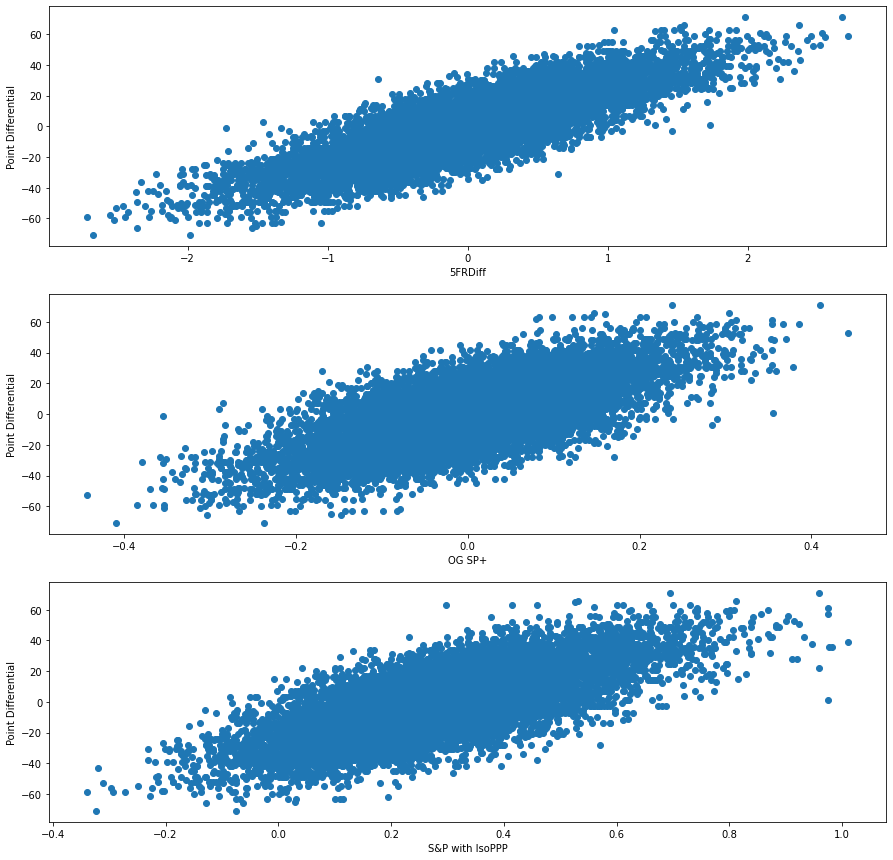

In [29]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [30]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.968029334766474


In [31]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.936352,0.714659
S&PIsoPPPDiff,0.936352,1.000000,0.705644
PtsDiff,0.714659,0.705644,1.000000


In [32]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612,1.325152,2.003140
0,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533,0.985621,0.190775
1,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
0,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265,0.229895,0.524632


In [33]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [34]:
# outliers

In [35]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612,1.325152,2.003140
1,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
0,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265,0.229895,0.524632
1,Ball State,2012,322432050.0,37.0,11.0,0.979920,96,0.437500,0.083333,6.291667,...,0.225997,0.136838,-1.198972,-1.220103,0.225997,0.136838,5.082632,0.165265,0.229895,0.524632


In [36]:
# Linear Regression Model
# from sklearn.linear_model import LinearRegression, SGDClassifier
# from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [37]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data["PtsDiff"][:, np.newaxis])

# print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Mean Pred Score: 0.4890446066856384
Pred Std Dev: 16.698123931884766
Mean Abs Error: 9.438537431970014
Mdn Abs Error: 7.948087692260742
R-squared: 0.6718411016114447
Adj R-squared: 0.6716913257564066



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.655627,0.567874,0.462858,0.781895,0.567980,0.570768,0.981299,0.369647,0.763874,...,0.167498,0.068818,-0.028275,-0.184180,-0.167498,0.068818,-0.028275,0.821285,0.824193,0.820607
OffSRDiff,0.655627,1.000000,0.478338,0.204142,0.578681,0.313404,0.381708,0.655069,0.755016,0.668885,...,0.133873,0.020096,-0.046143,-0.118913,-0.133873,0.020096,-0.046143,0.945958,0.947919,0.942978
OffERDiff,0.567874,0.478338,1.000000,0.139241,0.489876,0.295919,0.321156,0.558939,0.321653,0.812734,...,0.104128,-0.024010,-0.088467,-0.098768,-0.104128,-0.024010,-0.088467,0.556828,0.559846,0.556081
FPDiff,0.462858,0.204142,0.139241,1.000000,0.588771,0.047916,-0.000067,0.432337,-0.024791,0.203795,...,0.066413,0.367255,0.258458,-0.150001,-0.066413,0.367255,0.258458,0.300795,0.303055,0.301887
OppRateDiff,0.781895,0.578681,0.489876,0.588771,1.000000,0.138312,0.133733,0.780276,0.153499,0.637209,...,0.128100,0.066935,-0.037007,-0.158613,-0.128100,0.066935,-0.037007,0.692143,0.695228,0.690153
OppEffDiff,0.567980,0.313404,0.295919,0.047916,0.138312,1.000000,0.814844,0.564634,0.365089,0.413085,...,0.101295,-0.001421,-0.012608,-0.089568,-0.101295,-0.001421,-0.012608,0.483894,0.484382,0.483503
OppPPDDiff,0.570768,0.381708,0.321156,-0.000067,0.133733,0.814844,1.000000,0.573135,0.420393,0.446165,...,0.114245,-0.006210,-0.014913,-0.076028,-0.114245,-0.006210,-0.014913,0.566949,0.567587,0.564315
PPDDiff,0.981299,0.655069,0.558939,0.432337,0.780276,0.564634,0.573135,1.000000,0.369283,0.752806,...,0.163657,0.059022,-0.046211,-0.177223,-0.163657,0.059022,-0.046211,0.819638,0.822409,0.818320
OppSRDiff,0.369647,0.755016,0.321653,-0.024791,0.153499,0.365089,0.420393,0.369283,1.000000,0.449631,...,0.090918,-0.005640,-0.017906,-0.060424,-0.090918,-0.005640,-0.017906,0.704784,0.705331,0.702251
YPPDiff,0.763874,0.668885,0.812734,0.203795,0.637209,0.413085,0.446165,0.752806,0.449631,1.000000,...,0.156115,-0.016774,-0.084175,-0.145290,-0.156115,-0.016774,-0.084175,0.767013,0.769732,0.765954


In [38]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.735425,0.655627,0.752828,0.888427,0.292334,0.438576,0.821285,0.824193,0.820607
ActPts,0.735425,1.000000,0.461004,0.538444,0.645555,0.241455,0.305595,0.586619,0.590270,0.588589
Eff,0.655627,0.461004,1.000000,0.652855,0.734930,0.302195,0.261409,0.945958,0.947919,0.942978
Expl,0.752828,0.538444,0.652855,1.000000,0.732769,0.252709,0.248022,0.755134,0.758103,0.754544
FinDrv,0.888427,0.645555,0.734930,0.732769,1.000000,0.280574,0.384792,0.902577,0.904935,0.899281
FldPos,0.292334,0.241455,0.302195,0.252709,0.280574,1.000000,0.061211,0.338928,0.341839,0.340613
Trnovr,0.438576,0.305595,0.261409,0.248022,0.384792,0.061211,1.000000,0.421983,0.377429,0.376441
5FR,0.821285,0.586619,0.945958,0.755134,0.902577,0.338928,0.421983,1.000000,0.997555,0.992156
5FRDiff,0.824193,0.590270,0.947919,0.758103,0.904935,0.341839,0.377429,0.997555,1.000000,0.994647
PredPtsDiff,0.820607,0.588589,0.942978,0.754544,0.899281,0.340613,0.376441,0.992156,0.994647,1.000000


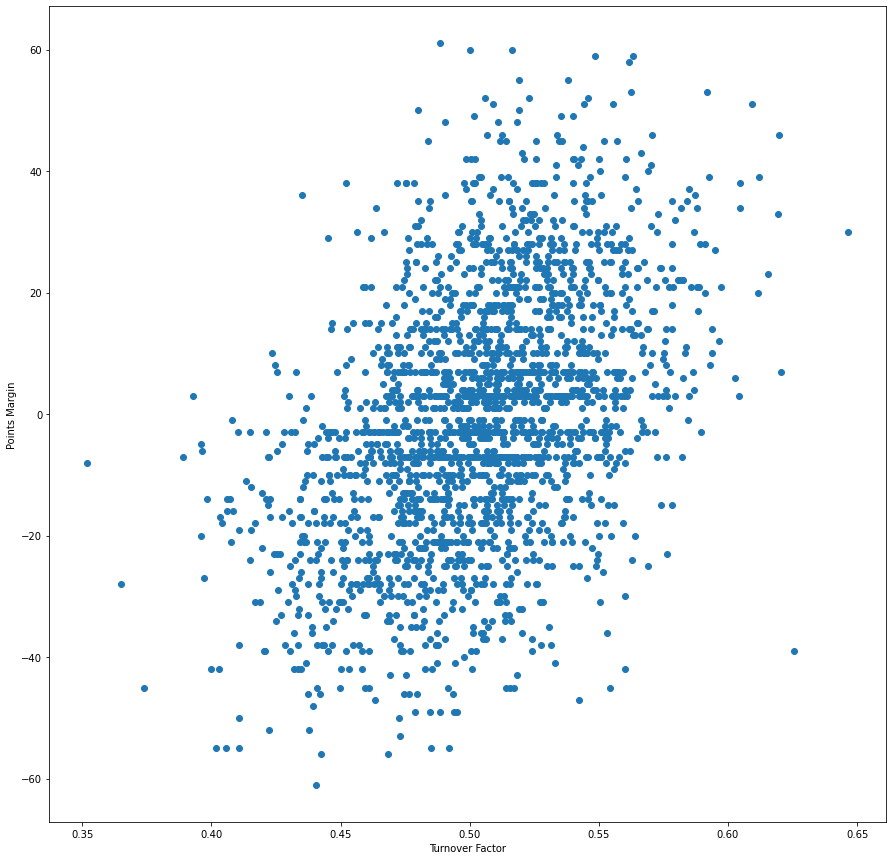

In [39]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

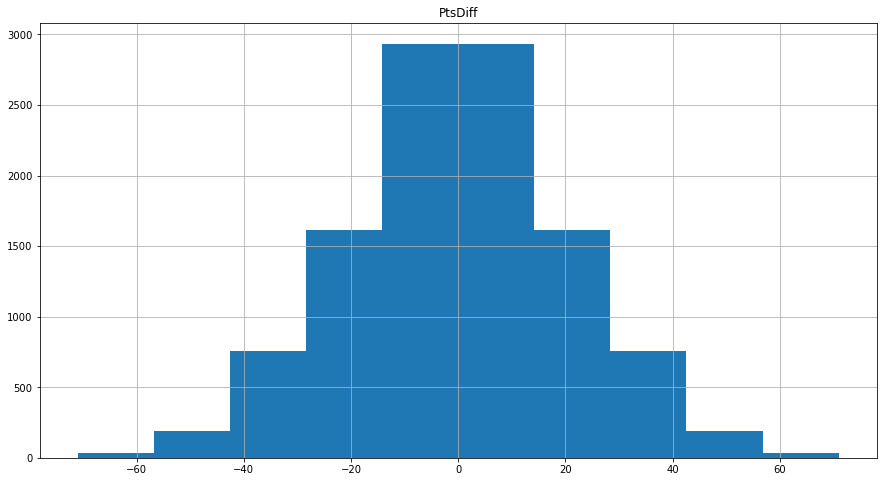

In [40]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

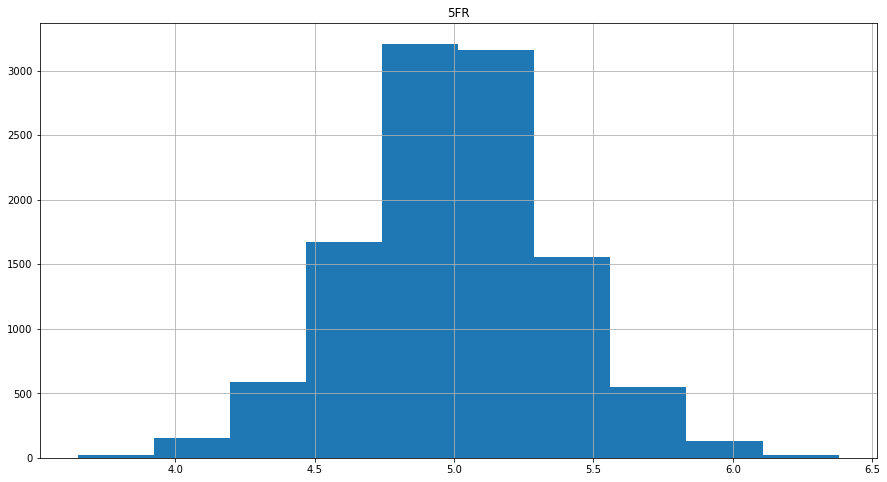

In [41]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

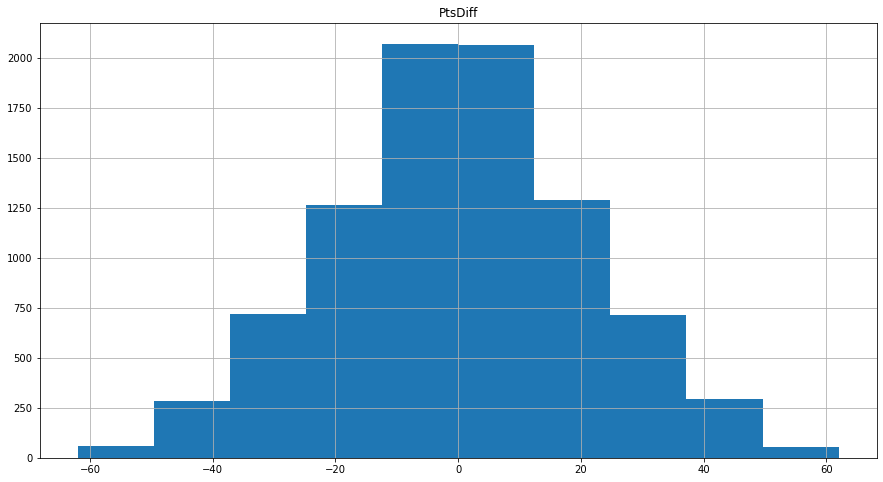

In [42]:
train_data.hist(column='PtsDiff', figsize=(15,8));

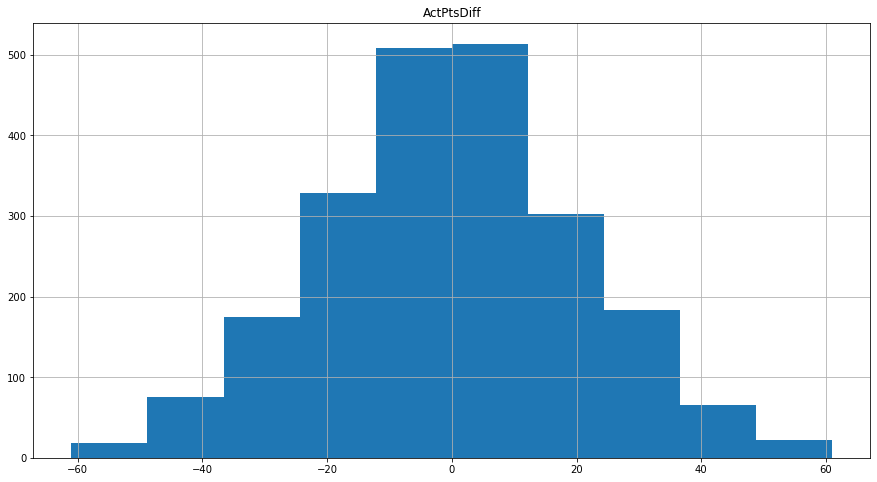

In [43]:
test.hist(column='ActPtsDiff', figsize=(15,8));

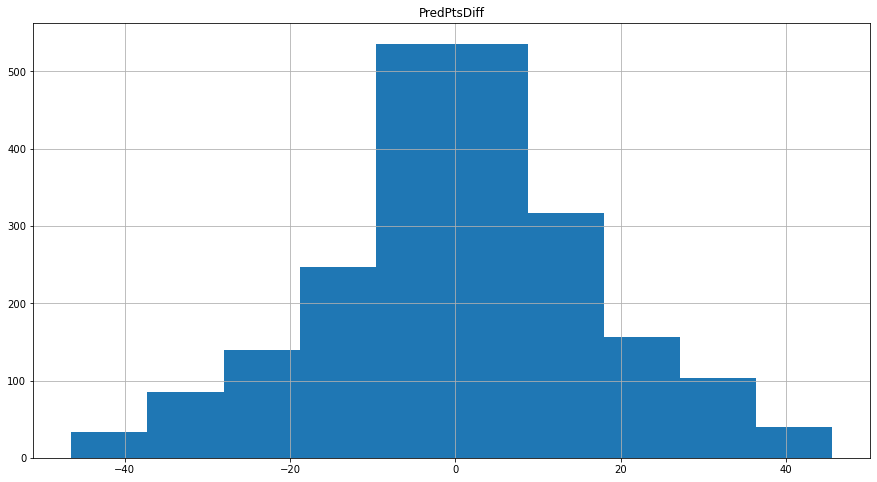

In [44]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [45]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [46]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4 (exact value: -4.374039173126221)
Z score: -0.2912353277206421
Win Prob for Virginia Tech: 38.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [47]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -3 (exact value: -3.3439128398895264)
Z score: -0.22954420745372772
Win Prob for Georgia Tech: 40.92%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.301587,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,4.964540,-0.116518
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.290323,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.081058,0.116518


In [48]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -3 (exact value: -2.9013144969940186)
Z score: -0.20303833484649658
Win Prob for Georgia Tech: 41.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.387500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.041941,0.084977
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.368421,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.956965,-0.084977


In [49]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by -1 (exact value: -0.8595243692398071)
Z score: -0.08076170086860657
Win Prob for Mississippi State: 46.78%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.366197,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.997160,0.018954
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.344828,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,4.978207,-0.018954


In [50]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3 (exact value: -2.9013144969940186)
Z score: -0.20303833484649658
Win Prob for Texas A&M: 41.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.355556,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.030207,0.06103
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.326923,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.969177,-0.06103


In [51]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(np.array([[tester['5FRDiff'].mean()]]))
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,LSU,0.950615,13,12.0,1.0
2,Ohio State,0.943747,13,12.0,1.0
3,Alabama,0.902906,12,11.0,1.0
4,Clemson,0.902532,13,12.0,1.0
5,Oklahoma,0.850480,13,11.0,2.0
6,Wisconsin,0.831667,13,11.0,2.0
7,Utah,0.826630,13,11.0,2.0
8,Louisiana,0.807883,13,11.0,2.0
9,Memphis,0.807883,13,11.0,2.0
10,UCF,0.797936,12,10.0,2.0


In [52]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
53,LSU,10.488997,2.511003
77,Ohio State,10.365347,2.634653
78,Oklahoma,9.250573,3.749427
115,Utah,8.143877,4.856123
75,Notre Dame,8.079277,3.920723
11,Baylor,7.646446,5.353554
110,UCF,7.547258,4.452742
57,Miami,7.476722,4.523278
56,Memphis,7.451474,5.548526
128,Wisconsin,7.434210,5.565790


In [53]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2022):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.397336,1.0
1,Florida State,2012,5.393616,2.0
2,Arizona State,2012,5.329176,3.0
3,Notre Dame,2012,5.308616,4.0
4,Georgia,2012,5.306786,5.0
5,Boise State,2012,5.300958,6.0
6,Ohio State,2012,5.288622,7.0
7,Fresno State,2012,5.267703,8.0
8,Bowling Green,2012,5.245412,9.0
9,Oklahoma,2012,5.243370,10.0


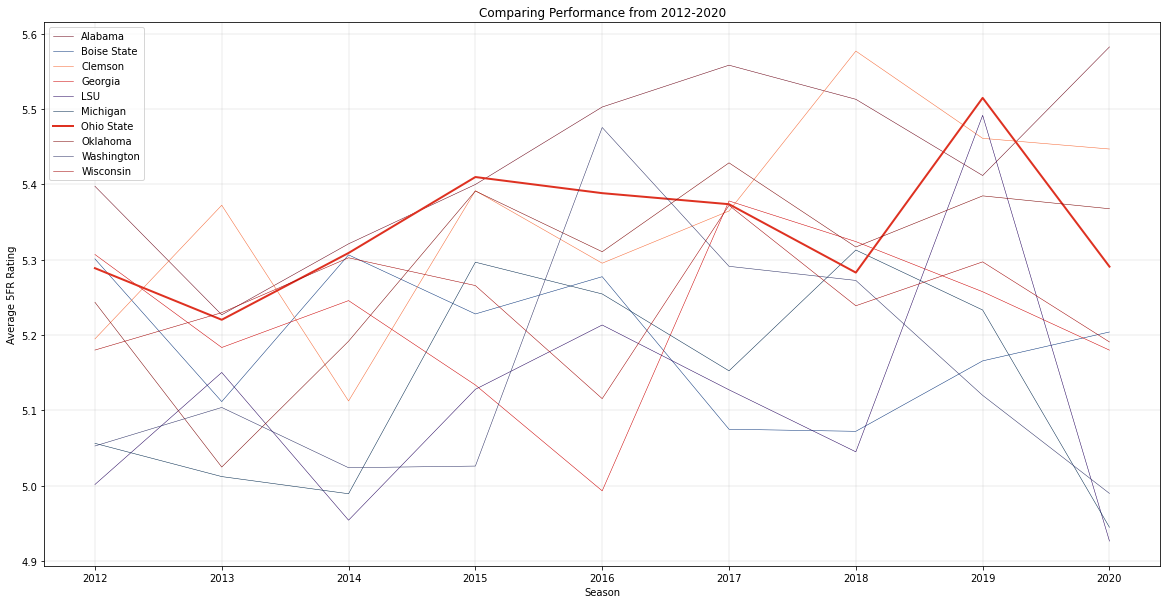

In [54]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [55]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.434649
1,Clemson,5.357211
2,Ohio State,5.341880
3,Oklahoma,5.295378
4,Wisconsin,5.243485
5,Georgia,5.222361
6,Boise State,5.193381
7,Appalachian State,5.180941
8,Notre Dame,5.166141
9,Washington,5.150491


In [56]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1020,Alabama,2020,5.582278,1.0
762,Clemson,2018,5.576754,1.0
125,Florida State,2013,5.569780,1.0
633,Alabama,2017,5.558014,1.0
891,Ohio State,2019,5.514619,1.0
763,Alabama,2018,5.512751,2.0
506,Alabama,2016,5.502508,1.0
1021,BYU,2020,5.496810,2.0
892,LSU,2019,5.491479,2.0
507,Washington,2016,5.475331,2.0


In [57]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
282,Georgia Tech,2014,5.113504,31.0
54,Georgia Tech,2012,5.028232,55.0
581,Georgia Tech,2016,4.935996,76.0
458,Georgia Tech,2015,4.919085,80.0
857,Georgia Tech,2018,4.892884,96.0
1103,Georgia Tech,2020,4.892534,84.0
984,Georgia Tech,2019,4.890379,94.0
729,Georgia Tech,2017,4.877783,97.0
214,Georgia Tech,2013,4.865628,90.0


In [58]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2021):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323290278.0,Fresno State,2012.0,Air Force,8.0
8,332502005.0,Utah State,2013.0,Air Force,1.0
9,332560068.0,Boise State,2013.0,Air Force,2.0


In [59]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict(np.array([[ffr_diff]]))
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2021, 0, -1, True)

[0.13937112545878344, -17.59751319885254]

In [60]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,5.501947,0.617991,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,3.648580,0.575038,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-7.466265,0.316888,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,3.064029,0.561277,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-7.466265,0.316888,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-3.343913,0.409223,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-0.859524,0.467816,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,7.350799,0.659438,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,3.518826,0.571991,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,3.857085,0.579925,True,BYU,BYU,Hawai'i,Hawai'i


In [61]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 16-24
ML Record: 26-14


In [62]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -3 (exact value: -3.3439128398895264)
Z score: -0.22954420745372772
Win Prob for Virginia: 40.92%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.378378,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,5.036311,0.113568
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.290909,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,4.922742,-0.113568


In [63]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 4.233218193054199)
Z score: 0.2242271900177002
Win Prob for North Carolina: 58.87%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.340426,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.105578,0.189469
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.320755,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.916109,-0.189469


In [64]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15 (exact value: 14.922983169555664)
Z score: 0.8644048571586609
Win Prob for Pittsburgh: 80.63%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.260870,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.286047,0.607556
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.163265,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.678491,-0.607556


In [65]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -13 (exact value: -13.436999320983887)
Z score: -0.8339884877204895
Win Prob for Auburn: 20.21%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.373333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.251737,0.521503
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.258065,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.730234,-0.521503


In [66]:
generate_win_prob(401110867, 2019)
# calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 24 (exact value: 23.6834659576416)
Z score: 1.3890435695648193
Win Prob for Georgia: 91.76%
---


[0.9175902491755819, 45.0]

In [67]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    if (row.Team == row.HomeTeam and row.ActualMOV > 0):
        return prob
    elif (row.Team == row.AwayTeam and row.ActualMOV < 0):
        return prob
    else:
        return 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

In [68]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

# calculate_box_score(401112511, 2019)[["OppPPDDiff","OppRateDiff","OppSRDiff"]]

# drives[(drives.game_id == 401112511) & (drives.offense == "Georgia Tech") & (drives.start_yardline + drives.yards >= 60)].drive_pts.mean()

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 19 (exact value: 18.76128387451172)
Z score: 1.094269037246704
Win Prob for Clemson: 86.31%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 8 (exact value: 8.488506317138672)
Z score: 0.4790635108947754
Win Prob for Georgia Tech: 68.41%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -6 (exact value: -6.101599216461182)
Z score: -0.39469367265701294
Win Prob for The Citadel: 34.65%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 8 (exact value: 8.252521514892578)
Z score: 0.46493107080459595
Win Prob for Temple: 67.90%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 4.233218193054199)
Z score: 0.2242271900177002
Win Prob fo

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401111653.0,2019,Georgia Tech,Clemson,Away,-20.268164,11.810533,-38.0,86.308150
1,401112441.0,2019,Georgia Tech,South Florida,Home,14.129081,79.299589,4.0,68.405328
2,401112452.0,2019,Georgia Tech,The Citadel,Home,39.906288,99.087679,-3.0,65.346551
3,401112469.0,2019,Georgia Tech,Temple,Away,0.843913,53.181249,-22.0,67.900959
4,401112475.0,2019,Georgia Tech,North Carolina,Home,-0.401314,47.873811,-16.0,41.129026
5,401112480.0,2019,Georgia Tech,Duke,Away,-10.752522,26.939344,-18.0,76.274769
6,401112488.0,2019,Georgia Tech,Miami,Away,-12.528405,23.545451,7.0,59.077702
7,401112498.0,2019,Georgia Tech,Pittsburgh,Home,-0.583053,47.440363,-10.0,19.368276
8,401112504.0,2019,Georgia Tech,Virginia,Away,-9.850799,28.751907,-5.0,40.922298
9,401112511.0,2019,Georgia Tech,Virginia Tech,Home,-1.987056,44.105846,-45.0,0.387079


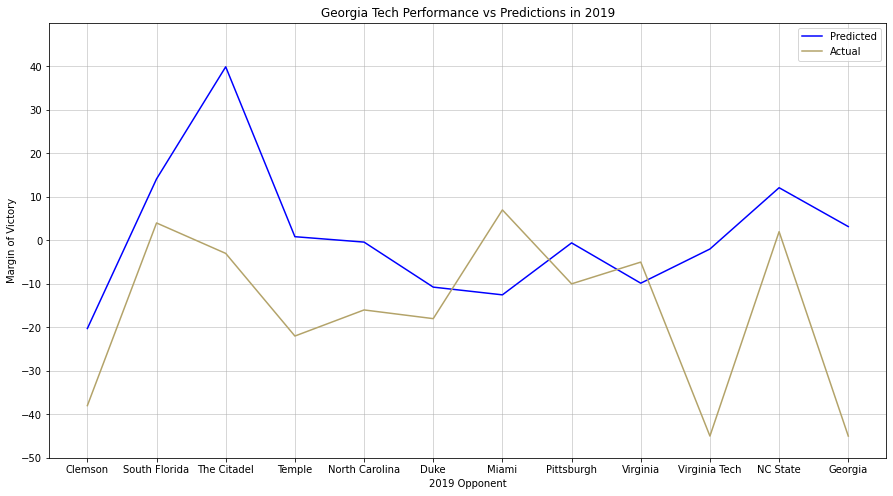

In [69]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 36 (exact value: 35.65000915527344)
Z score: 2.1056835651397705
Win Prob for Georgia Tech: 98.24%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -6 (exact value: -5.976956844329834)
Z score: -0.38722923398017883
Win Prob for South Florida: 34.93%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by -3 (exact value: -2.9013144969940186)
Z score: -0.20303833484649658
Win Prob for Pittsburgh: 41.96%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 38 (exact value: 37.905147552490234)
Z score: 2.240736961364746
Win Prob for Clemson: 98.75%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 37 (exact value: 37.406288146972656)
Z score:

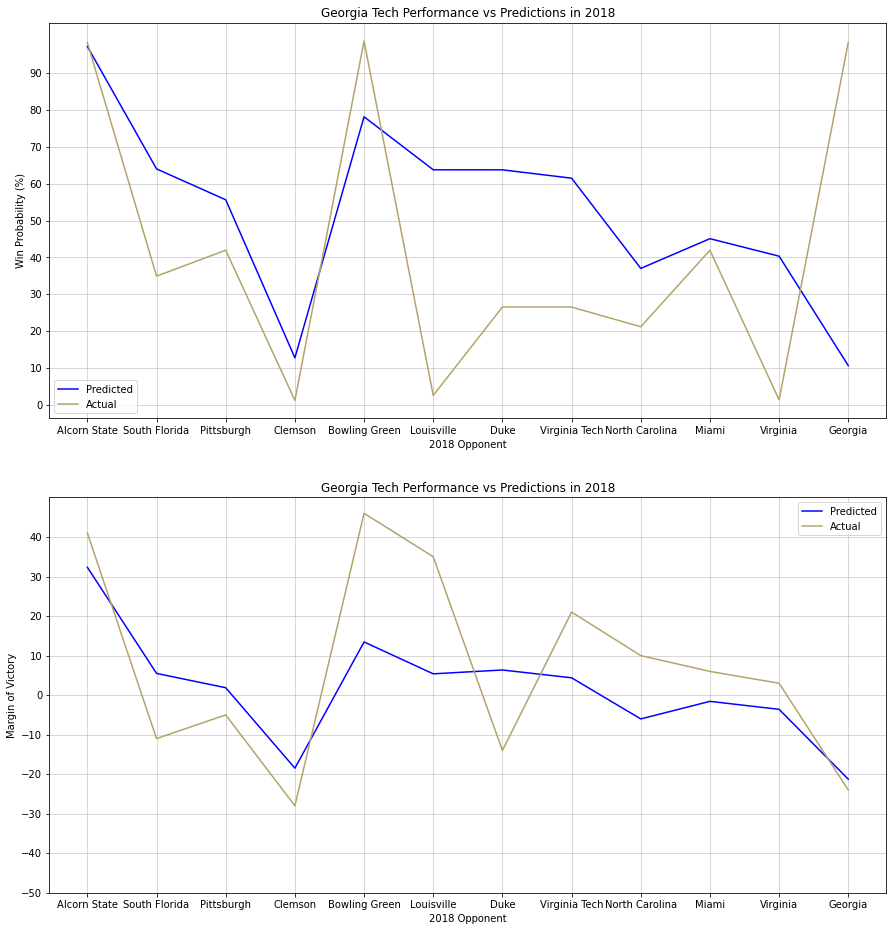

In [70]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

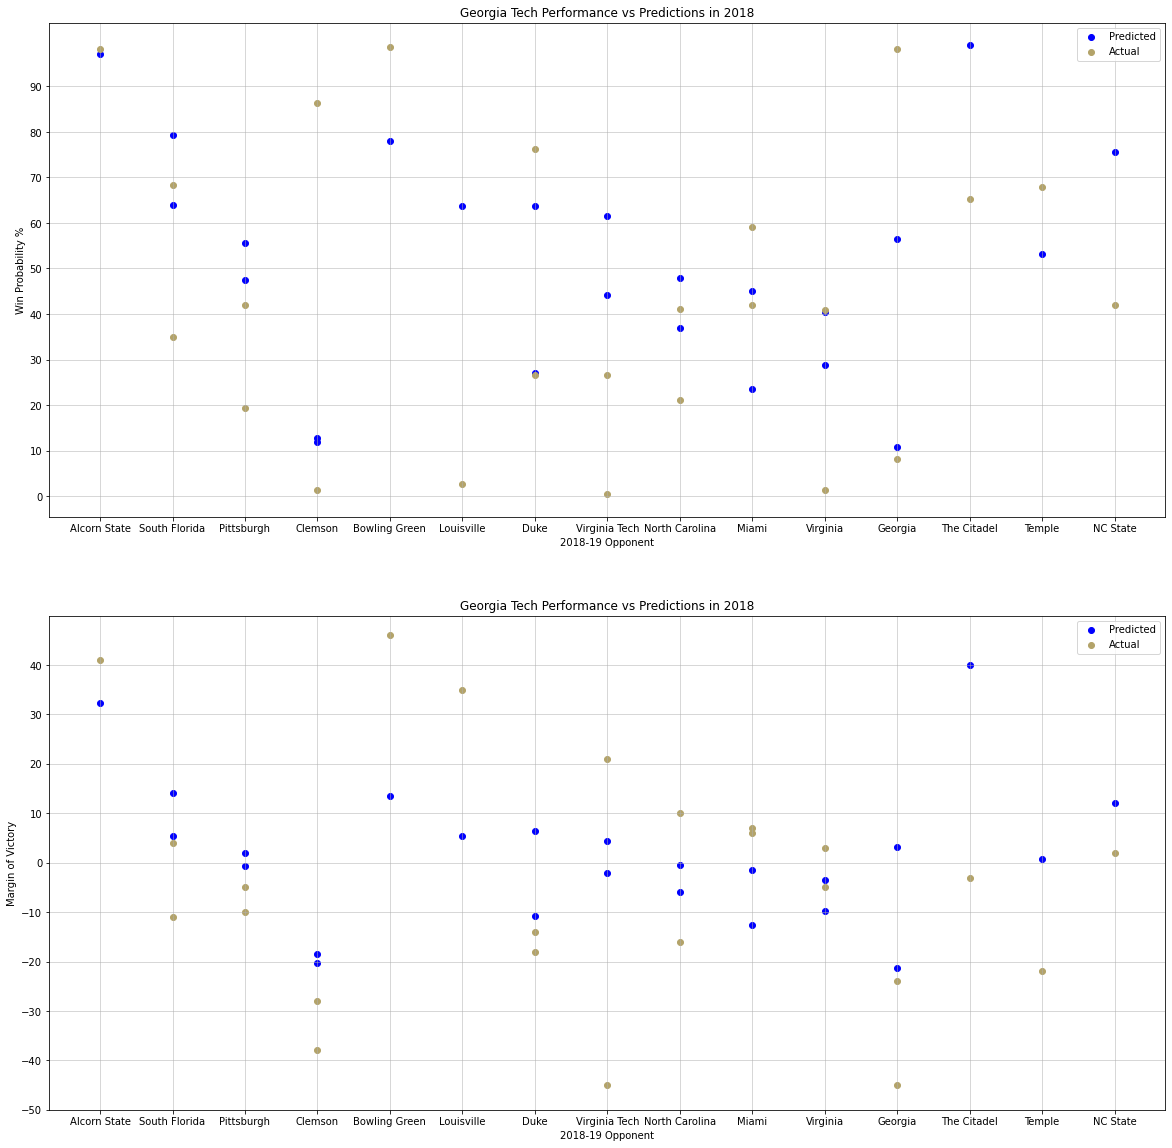

In [71]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [72]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.569106,0.455439,0.442681,0.314348,0.252383,0.275152,0.317477,0.373074
2013,0.569106,1.000000,0.463384,0.339954,0.237391,0.274508,0.181575,0.268311,0.123710
2014,0.455439,0.463384,1.000000,0.541582,0.368218,0.242186,0.236723,0.282047,0.222728
2015,0.442681,0.339954,0.541582,1.000000,0.599137,0.459474,0.365219,0.394518,0.299783
2016,0.314348,0.237391,0.368218,0.599137,1.000000,0.510219,0.323631,0.458054,0.316456
2017,0.252383,0.274508,0.242186,0.459474,0.510219,1.000000,0.592307,0.491428,0.321551
2018,0.275152,0.181575,0.236723,0.365219,0.323631,0.592307,1.000000,0.569259,0.379863
2019,0.317477,0.268311,0.282047,0.394518,0.458054,0.491428,0.569259,1.000000,0.560937
2020,0.373074,0.123710,0.222728,0.299783,0.316456,0.321551,0.379863,0.560937,1.000000


In [73]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.32932070716231


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,29.985484,-9.252522
1,2020,Georgia Tech,UCF,Home,49.167279,0.140476
2,2020,Georgia Tech,Syracuse,Away,57.742419,2.772237
3,2020,Georgia Tech,Louisville,Home,49.167279,0.140476
4,2020,Georgia Tech,Clemson,Home,9.996068,-20.914204
5,2020,Georgia Tech,Boston College,Away,50.832721,-0.140476
6,2020,Georgia Tech,Notre Dame,Home,15.923861,-16.168871
7,2020,Georgia Tech,Pittsburgh,Home,42.257581,-2.772237
8,2020,Georgia Tech,Miami,Away,24.627858,-11.948088
9,2020,Georgia Tech,Duke,Home,52.398800,1.493692


In [74]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.501395055167372


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,24.627858,-11.948088
1,2019,Georgia Tech,South Florida,Home,58.476351,4.064029
2,2019,Georgia Tech,The Citadel,Home,97.427967,33.013405
3,2019,Georgia Tech,Temple,Away,38.816144,-5.233218
4,2019,Georgia Tech,North Carolina,Home,53.677242,2.030376
5,2019,Georgia Tech,Duke,Away,46.322758,-2.030376
6,2019,Georgia Tech,Miami,Away,40.464914,-4.518826
7,2019,Georgia Tech,Pittsburgh,Home,44.308532,-1.901314
8,2019,Georgia Tech,Virginia,Away,38.816144,-5.233218
9,2019,Georgia Tech,Virginia Tech,Home,44.308532,-1.901314


In [75]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 19908


In [76]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [77]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 593 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 586 games with betting lines for 2013 season.
[Simulation] Creating projections for 586 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 609 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 561 games with betting lines for 2014 season.
[Simulation] Creating projections for 561 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 652 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 623 games with betting lines for 2015 season.
[Simulation] Creating projections for 623 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,439,147,0,0.749147
1,ATS,2013,334,245,7,0.569966
0,ML,2014,424,137,0,0.755793
1,ATS,2014,335,213,13,0.597148
0,ML,2015,476,147,0,0.764045
1,ATS,2015,360,246,17,0.577849
0,ML,2016,466,149,0,0.757724
1,ATS,2016,369,229,17,0.600000
0,ML,2017,499,171,0,0.744776
1,ATS,2017,382,270,18,0.570149


In [78]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $3132.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,334,245,7,0.569966,2930,322.5,20.156250,0.110068
1,ATS,2014,335,213,13,0.597148,2805,503.5,31.468750,0.179501
1,ATS,2015,360,246,17,0.577849,3115,447.0,29.800000,0.143499
1,ATS,2016,369,229,17,0.600000,3075,585.5,39.033333,0.190407
1,ATS,2017,382,270,18,0.570149,3350,425.0,28.333333,0.126866
1,ATS,2018,343,257,17,0.555916,3085,301.5,20.100000,0.097731
1,ATS,2019,372,284,10,0.558559,3330,298.0,19.866667,0.089489
1,ATS,2020,252,184,8,0.567568,2220,248.0,15.500000,0.111712


In [79]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7537983196558147
Avg ATS Win %: 0.5746442548325612


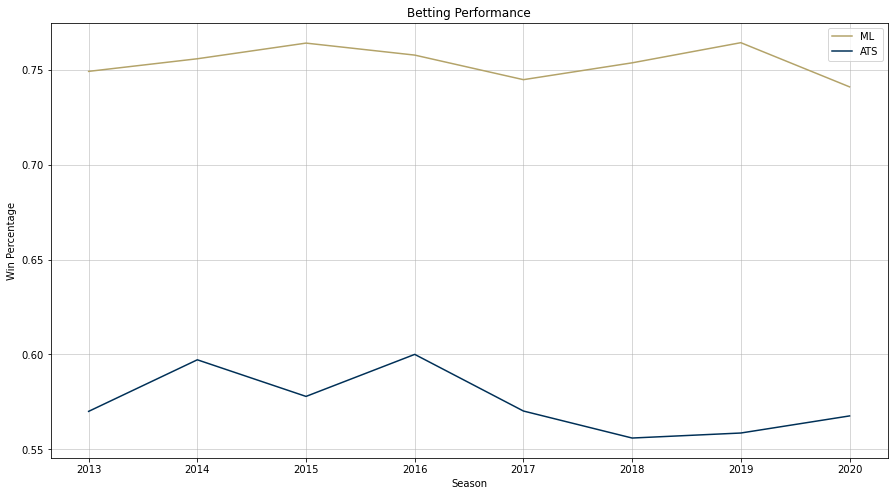

In [80]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [81]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [82]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6194076563823712, 5.5640294551849365]

In [83]:
# generate_win_prob(401135295, 2019)

In [84]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [85]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,0.747196,1
77,Ohio State,0.574492,2
78,Oklahoma,0.440392,3
2,Alabama,0.418786,4
21,Clemson,0.391728,5
9,Auburn,0.253241,6
34,Georgia,0.251089,7
127,Wisconsin,0.245402,8
114,Utah,0.197236,9
29,Florida,0.190582,10


In [86]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 7.738315105438232)
Z score: 0.4341368079185486
Win Prob for Georgia Tech: 66.79%
---


[0.6679054509903805, 3.0]

In [87]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.252521514892578)
Z score: 0.46493107080459595
Win Prob for UCF: 67.90%
---


[0.679009590428932, 28.0]

In [88]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.9013144969940186)
Z score: -0.20303833484649658
Win Prob for Syracuse: 41.96%
---


[0.41955253466162146, 17.0]

In [89]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 14 (exact value: 14.09817123413086)
Z score: 0.815009355545044
Win Prob for Georgia Tech: 79.25%
---


[0.7924665225412182, 19.0]

In [90]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5232361008791828, 1.4621651470661163]

In [91]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,9.252522,0.700145,False,Miami,Virginia
0,Texas,Baylor,10.5,6.501947,0.640612,False,Texas,Baylor
0,BYU,Texas State,28.0,15.419787,0.814381,False,BYU,Texas State
0,Michigan,Minnesota,3.0,11.028405,0.736035,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,11.028405,0.736035,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,20.952888,0.889810,False,Ohio State,Nebraska


In [92]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020


In [93]:
sched_2020 = generate_schedule_analysis(team = "Georgia Tech", year = 2020)
sched_2020

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 7.738315105438232)
Z score: 0.4341368079185486
Win Prob for Georgia Tech: 66.79%
---
Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.252521514892578)
Z score: 0.46493107080459595
Win Prob for UCF: 67.90%
---
Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.9013144969940186)
Z score: -0.20303833484649658
Win Prob for Syracuse: 41.96%
---
Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 14 (exact value: 14.09817123413086)
Z score: 0.815009355545044
Win Prob for Georgia Tech: 79.25%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 66.0
Proj MOV: Clemson by 36 (exact value: 35.747276306152344)
Z score: 2.11150860786438
Win Prob for Clemson: 98.26%
---
Game: Georg

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401234563.0,2020,Georgia Tech,Florida State,Away,-11.028405,26.396458,3.0,33.209455
1,401234568.0,2020,Georgia Tech,UCF,Home,4.064029,58.476351,-28.0,32.099041
2,401234594.0,2020,Georgia Tech,Syracuse,Away,1.901314,55.691468,-17.0,41.955253
3,401234601.0,2020,Georgia Tech,Louisville,Home,-1.901314,44.308532,19.0,79.246652
4,401234610.0,2020,Georgia Tech,Clemson,Home,-22.177773,8.731962,-66.0,1.736431
5,401234617.0,2020,Georgia Tech,Boston College,Away,2.343913,56.736014,-21.0,57.503785
6,401234626.0,2020,Georgia Tech,Notre Dame,Home,-4.022425,39.351158,-18.0,17.337035
7,401234652.0,2020,Georgia Tech,Duke,Home,-1.422906,45.442036,23.0,57.992504
8,401234659.0,2020,Georgia Tech,NC State,Away,1.901314,55.691468,-10.0,57.503785
9,401261245.0,2020,Georgia Tech,Pittsburgh,Home,4.648580,59.835905,-14.0,33.209455


In [94]:
print(f"Expected 2nd order wins: {sched_2020.PostGameWinProb.sum() / 100}")

Expected 2nd order wins: 4.117933954056896


In [95]:
model.save_model('pgwp_model.model')

In [96]:
opp_2021_df = pd.DataFrame(data={
    "Team" : ["Northern Illinois","Kennesaw State","Clemson","North Carolina","Pittsburgh","Duke","Virginia","Virginia Tech","Miami","Boston College","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Away","Neutral","Home","Away","Away","Home","Away","Home","Away","Home"]
})
georgia_tech_2021 = generate_schedule_predictions("Georgia Tech", opp_2021_df, 2021)
print(f"Expected 2nd order wins: {georgia_tech_2021.PredWinProb.sum() / 100}")
georgia_tech_2021

Expected 2nd order wins: 5.079404532329728


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2021,Georgia Tech,Northern Illinois,Home,68.935531,8.738315
1,2021,Georgia Tech,Kennesaw State,Home,99.512008,43.640732
2,2021,Georgia Tech,Clemson,Away,8.720391,-23.168037
3,2021,Georgia Tech,North Carolina,Neutral,31.688781,-7.466265
4,2021,Georgia Tech,Pittsburgh,Home,44.308532,-1.901314
5,2021,Georgia Tech,Duke,Away,56.736014,2.343913
6,2021,Georgia Tech,Virginia,Away,40.164095,-4.648580
7,2021,Georgia Tech,Virginia Tech,Home,40.852209,-3.374039
8,2021,Georgia Tech,Miami,Away,29.985484,-9.252522
9,2021,Georgia Tech,Boston College,Home,59.535086,4.518826
